# APPENDIX- Bayesian Analysis of ARPAV time series on temperatures

 - Chiara Tramarin - 1193231
 - Tuscano Alessio - 1193922

## IMPORT RAW DATA (https://www.arpa.veneto.it/dati-ambientali/open-data)

In [1]:
library(lubridate, warn.conflicts = FALSE)
library(data.table)
library(coda)
library(R2jags)
library(plotly)


#Function that takes a filename and gives out a data frames called "processed data" with some informations
import_data <- function(filename) {
  
  # Load the data from the CSV file
  raw_data <- read.csv(filename)
  
  # Convert the 'date' column to Date type and filter the data
  raw_data$date <- as.Date(raw_data$date)
  filtered_data <- subset(raw_data, date >= as.Date('1993-01-01') & date <= as.Date('2021-12-31'))
  
  # Create a new data frame named processed data with changing the names of the columns
  processed_data <- data.frame(
    Date = filtered_data$date,
    Max_Temperature = filtered_data$TMAX,
    Min_Temperature = filtered_data$TMIN,
    Mean_Temperature = filtered_data$TMED
  )
  
  # Add columns for year, month, week, and day
  processed_data$Year <- year(processed_data$Date)
  processed_data$Month <- month(processed_data$Date)
  processed_data$Week <- week(processed_data$Date)
  processed_data$Day <- day(processed_data$Date)
  
  # Calculate the temperature range and add it as a new column
  processed_data$Temperature_range_in_a_day <- abs(processed_data$Max_Temperature - processed_data$Min_Temperature)
  
  return(processed_data)
}



Caricamento pacchetto: 'data.table'


I seguenti oggetti sono mascherati da 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


Caricamento del pacchetto richiesto: rjags

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs


Caricamento pacchetto: 'R2jags'


Il seguente oggetto è mascherato da 'package:coda':

    traceplot


Caricamento del pacchetto richiesto: ggplot2


Caricamento pacchetto: 'plotly'


Il seguente oggetto è mascherato da 'package:ggplot2':

    last_plot


Il seguente oggetto è mascherato da 'package:stats':

    filter


Il seguente oggetto è mascherato da 'package:graphics':

    layout




In [2]:
#loading all the 5 files

# Define the file paths
file_paths <- c(
  "./raw_data/101_Porto Tolle - Pradon_Temperatura aria a 2m.csv",
  "./raw_data/119_Roverchiara_Temperatura aria a 2m.csv",
  "./raw_data/34_CASTELFRANCO VENETO_TMINMAX.csv", #HO SOLO FINO A 2004
  "./raw_data/53_Auronzo_Temperatura aria a 2m.csv"
)

# Import data from all files using the import_data function defined above
data_list <- lapply(file_paths, import_data)

# Display the head of each dataframe
#lapply(data_list, head)

In [3]:
#creating a function to extract more informations from dataframe mydf
aggregate_data <- function(mydf) {
   # Aggregate data to get monthly averages(mean value, month by month for every year)
    monthly_avg <- aggregate(
        cbind(Min_Temperature, Max_Temperature, Mean_Temperature) ~ Month + Year,
        data = mydf,
        FUN = mean
    )
    colnames(monthly_avg)[3:5] <- c("Mean_min_temp_month", "Mean_max_temp_month", "Mean_avg_temp_month")
    
    
    # Aggregate data to get annual averages
    annual_avg <- aggregate(
        cbind(Max_Temperature, Min_Temperature, Temperature_range_in_a_day, Mean_Temperature) ~ Year,
        data = mydf,
        FUN = mean
    )
   colnames(annual_avg)[2:5] <- c("Mean_Max_Temperature", "Mean_Min_Temperature", "Mean_Temperature_range", "Mean_Average_Temperature")

    return(list(monthly_averages = monthly_avg, annual_averages = annual_avg))
}

#Analyzing just the first one (PORTO TOLLE)
df_PORTOTOLLE <- data_list[[1]]
#applying the function to df_PORTOTOLLE
aggregated_PORTOTOLLE<-aggregate_data(df_PORTOTOLLE)

df1<-aggregated_PORTOTOLLE[[1]]
df2<-aggregated_PORTOTOLLE[[2]]

#head(df1)
#head(df2)


In [4]:
#Analyzing the second one (ROVERCHIARA)
df_ROVERCHIARA <- data_list[[2]]
aggregated_ROVERCHIARA<-aggregate_data(df_ROVERCHIARA)

df3<-aggregated_ROVERCHIARA[[1]]
df4<-aggregated_ROVERCHIARA[[2]]

#Analyzing the third one (CASTELFRANCO)
df_CASTELFRANCO <- data_list[[3]]
aggregated_CASTELFRANCO<-aggregate_data(df_CASTELFRANCO)

df5<-aggregated_CASTELFRANCO[[1]]
df6<-aggregated_CASTELFRANCO[[2]]

#Analyzing the fourth one (AURONZO)
df_AURONZO <- data_list[[4]]
aggregated_AURONZO<-aggregate_data(df_AURONZO)

df7<-aggregated_AURONZO[[1]]
df8<-aggregated_AURONZO[[2]]


# Part 0: 
## Study the evolution over time of the min, max and average temperatures computed over one month
We dediced to study the evolution over 1993-2021 for the month of January: \
we analyzed how the temperature varies day by day over a fixed month (January) to determine whether there is a significant variation in temperatures within a thirty-one day period or if it remains relatively constant. This provides an indication of one component of the noise in our data. The findings show that there is a variation of approximately 5 to 10 degrees between different days within the same month.

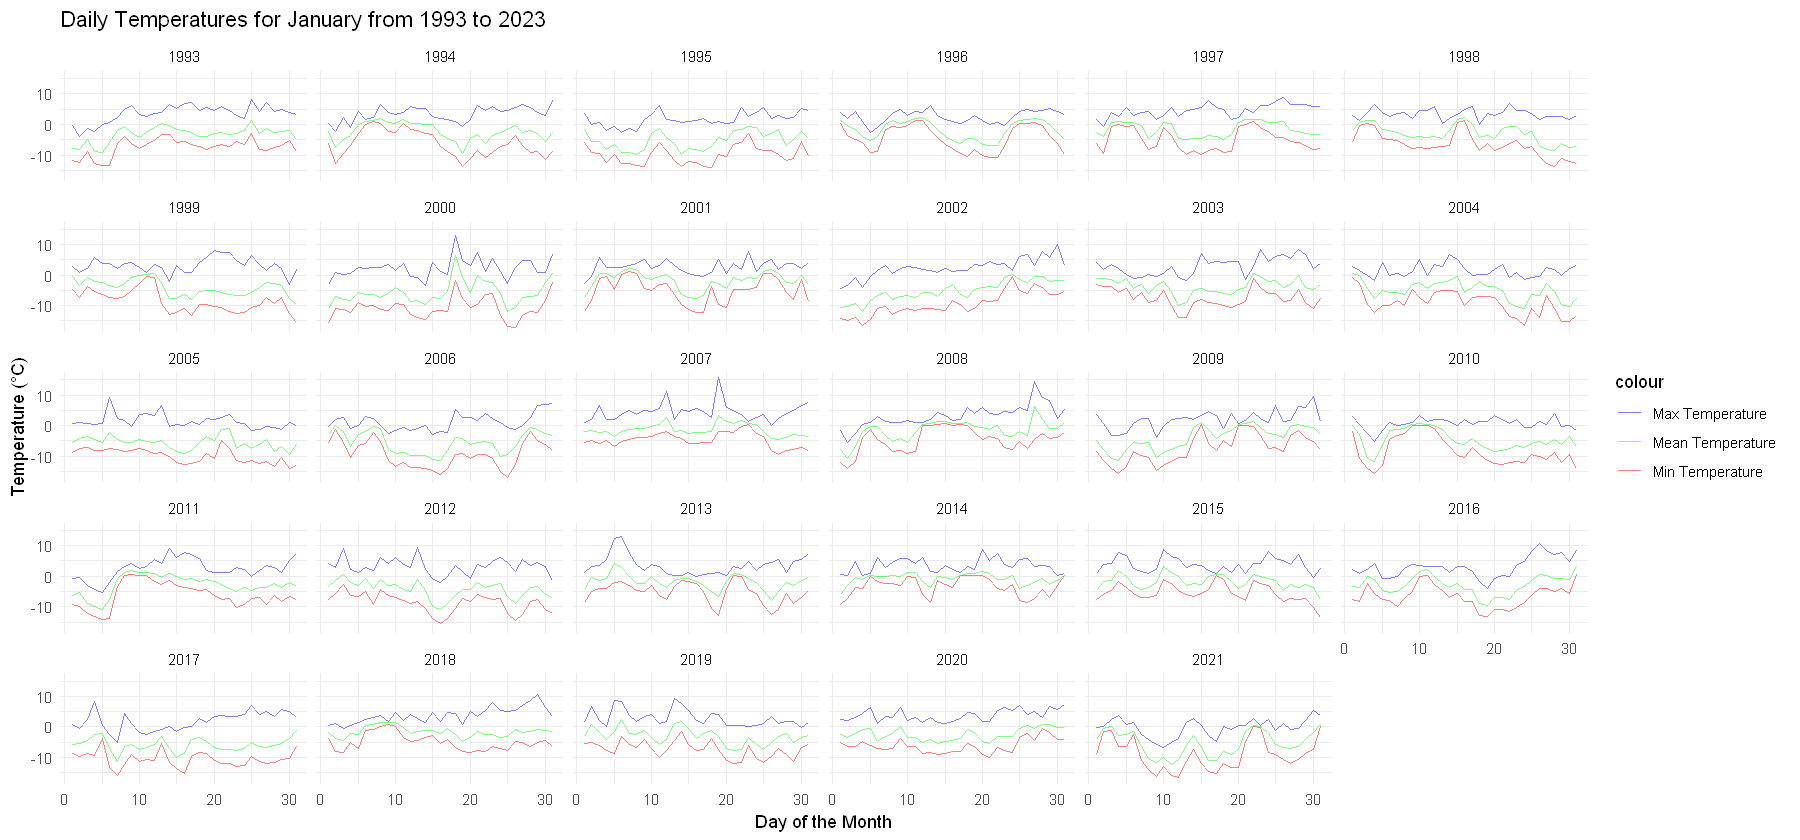

In [5]:
options(repr.plot.width=15)
#par(mfrow = c(2, 2))

# Filter data for the selected month (January in this example)
selected_month <- 1
monthly_data <- subset(df_AURONZO, Month == selected_month)

# Plot using ggplot2
ggplot(monthly_data, aes(x = Day, group = Year)) +
  geom_line(aes(y = Max_Temperature, color = "Max Temperature"), alpha = 0.5) +
  geom_line(aes(y = Min_Temperature, color = "Min Temperature"), alpha = 0.5) +
  geom_line(aes(y = Mean_Temperature, color = "Mean Temperature"), alpha = 0.5) +
  labs(x = "Day of the Month", y = "Temperature (°C)", 
       title = paste("Daily Temperatures for January from 1993 to 2023")) +
  scale_color_manual(values = c("Max Temperature" = "blue", "Min Temperature" = "red", "Mean Temperature" = "green")) +
  theme_minimal() +
  facet_wrap(~ Year)


# Part 1:
## Analysis of the evolution of the annual average of the min, max and daily average temperature over time (1993 - 2021): 
## • study the trend of the annual averages and compare them with a constant value or a rising trend (for instance linear or quadratic)



Here, we have calculated the minimum, maximum, and average mean temperatures for each year and plotted them alongside their respective linear and quadratic fits.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


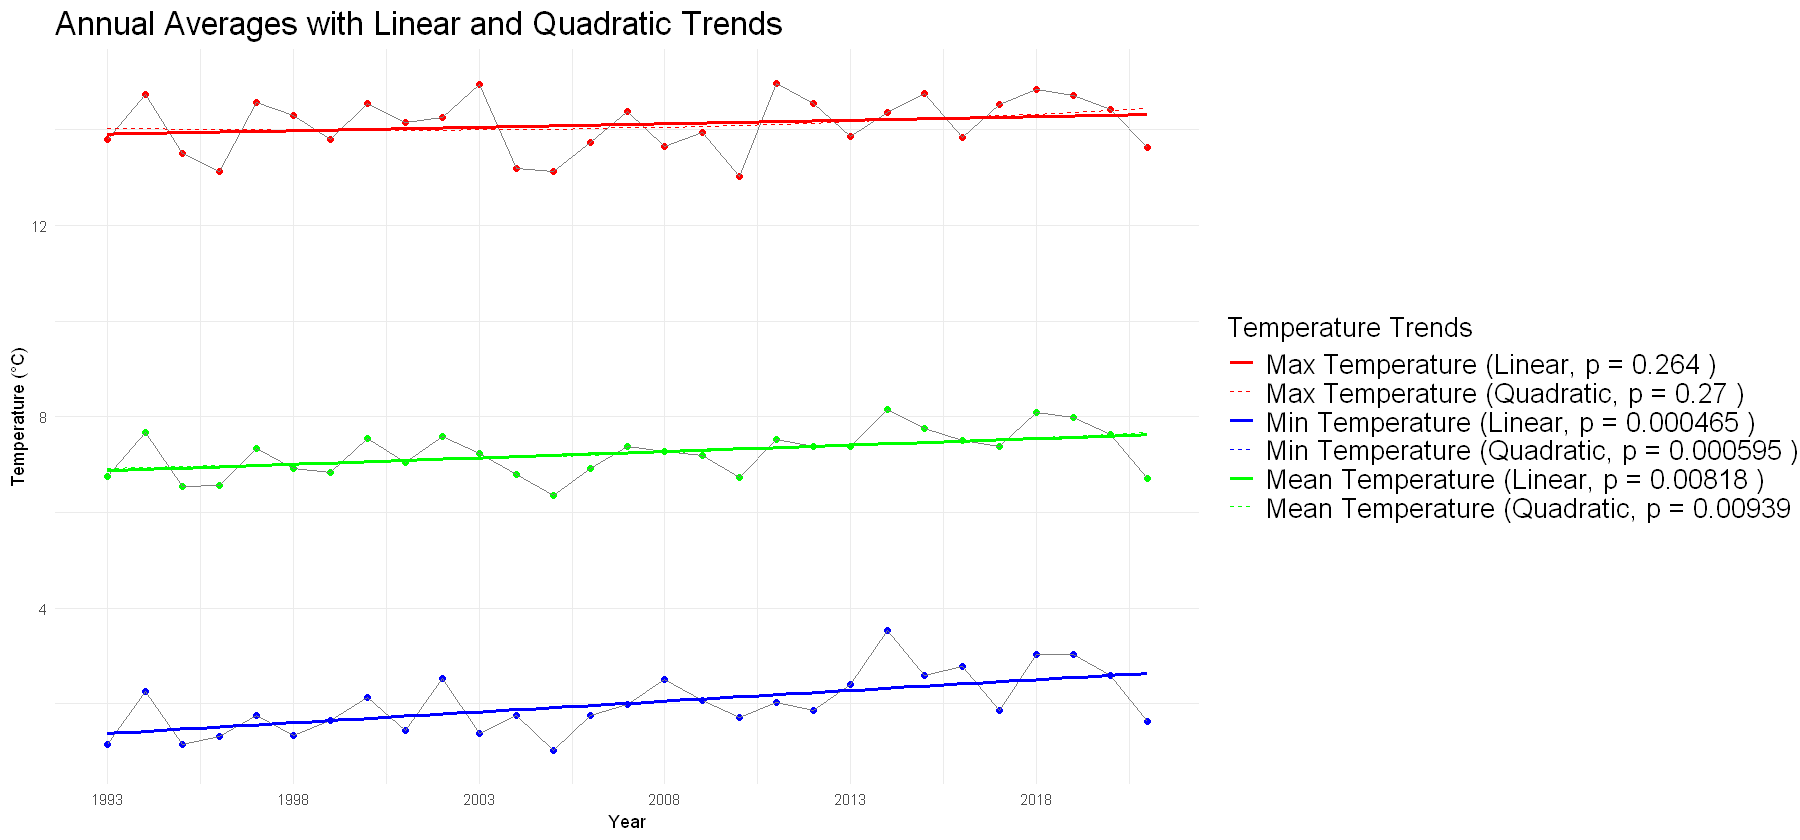

In [6]:

# Load tidyverse
#library(tidyverse)

# Calculate annual averages for Max, Min, and Mean temperatures
annual_avg <- df_AURONZO%>%
  group_by(Year) %>%
  summarise(Max_Temperature = mean(Max_Temperature, na.rm = TRUE),
            Min_Temperature = mean(Min_Temperature, na.rm = TRUE),
            Mean_Temperature = mean(Mean_Temperature, na.rm = TRUE))

# Fit linear and quadratic models to the annual average data
linear_model_max <- lm(Max_Temperature ~ Year, data = annual_avg)
quadratic_model_max <- lm(Max_Temperature ~ poly(Year, 2), data = annual_avg)

linear_model_min <- lm(Min_Temperature ~ Year, data = annual_avg)
quadratic_model_min <- lm(Min_Temperature ~ poly(Year, 2), data = annual_avg)

linear_model_mean <- lm(Mean_Temperature ~ Year, data = annual_avg)
quadratic_model_mean <- lm(Mean_Temperature ~ poly(Year, 2), data = annual_avg)

# Extract p-values
linear_p_max <- summary(linear_model_max)$coefficients[2, 4]
quadratic_p_max <- summary(quadratic_model_max)$coefficients[2, 4]

linear_p_min <- summary(linear_model_min)$coefficients[2, 4]
quadratic_p_min <- summary(quadratic_model_min)$coefficients[2, 4]

linear_p_mean <- summary(linear_model_mean)$coefficients[2, 4]
quadratic_p_mean <- summary(quadratic_model_mean)$coefficients[2, 4]

# Custom labels including p-values
labels <- c(
  paste("Max Temperature (Linear, p =", format(linear_p_max, digits = 3), ")"),
  paste("Max Temperature (Quadratic, p =", format(quadratic_p_max, digits = 3), ")"),
  paste("Min Temperature (Linear, p =", format(linear_p_min, digits = 3), ")"),
  paste("Min Temperature (Quadratic, p =", format(quadratic_p_min, digits = 3), ")"),
  paste("Mean Temperature (Linear, p =", format(linear_p_mean, digits = 3), ")"),
  paste("Mean Temperature (Quadratic, p =", format(quadratic_p_mean, digits = 3), ")")
)

# Plot annual averages and fitted models using ggplot2
ggplot(annual_avg, aes(x = Year)) +
  geom_point(aes(y = Max_Temperature, color = "Max Temperature")) +
  geom_line(aes(y = Max_Temperature, color = "lightblue")) +
  geom_point(aes(y = Min_Temperature, color = "Min Temperature")) +
  geom_line(aes(y = Min_Temperature, color = "lightcoral")) +
  geom_point(aes(y = Mean_Temperature, color = "Mean Temperature")) +
  geom_line(aes(y = Mean_Temperature, color = "lightgreen")) +
  geom_smooth(aes(y = Max_Temperature, color = "Max Temperature (Linear)"), method = "lm", se = FALSE) +
  geom_line(aes(y = predict(quadratic_model_max, newdata = annual_avg), color = "Max Temperature (Quadratic)"), linetype = "dashed") +
  geom_smooth(aes(y = Min_Temperature, color = "Min Temperature (Linear)"), method = "lm", se = FALSE) +
  geom_line(aes(y = predict(quadratic_model_min, newdata = annual_avg), color = "Min Temperature (Quadratic)"), linetype = "dashed") +
  geom_smooth(aes(y = Mean_Temperature, color = "Mean Temperature (Linear)"), method = "lm", se = FALSE) +
  geom_line(aes(y = predict(quadratic_model_mean, newdata = annual_avg), color = "Mean Temperature (Quadratic)"), linetype = "dashed") +
  labs(x = "Year", y = "Temperature (°C)", 
       title = "Annual Averages with Linear and Quadratic Trends") +
 scale_x_continuous(breaks = seq(min(annual_avg$Year), max(annual_avg$Year), by = 5)) +
  scale_color_manual(name = "Temperature Trends", 
                     values = c("Max Temperature" = "red", 
                                "Min Temperature" = "blue", 
                                "Mean Temperature" = "green",
                                "Max Temperature (Linear)" = "red",
                                "Max Temperature (Quadratic)" = "red",
                                "Min Temperature (Linear)" = "blue",
                                "Min Temperature (Quadratic)" = "blue",
                                "Mean Temperature (Linear)" = "green",
                                "Mean Temperature (Quadratic)" = "green"),
                     breaks = c("Max Temperature (Linear)", 
                                "Max Temperature (Quadratic)", 
                                "Min Temperature (Linear)", 
                                "Min Temperature (Quadratic)", 
                                "Mean Temperature (Linear)", 
                                "Mean Temperature (Quadratic)"),
                     labels = labels) +
  
  theme_minimal()+
theme(legend.title = element_text(size = 16),
  legend.text = element_text(size = 16),
 plot.title = element_text(size =20 ) )




The study shows a noticeable increase in temperature over the years, indicated by the positive slope of the linear fits. The quadratic fit also suggests a similar trend to the linear fits. Therefore, for subsequent annual analyses, we will proceed with the assumption of a linear increasing trend in temperature.
Here we have the summerize of the values of the six fits.

In [7]:
# Function to extract model summary
extract_model_summary <- function(model) {
  summary_model <- summary(model)
  return(list(
    coefficients = summary_model$coefficients,
    r_squared = summary_model$r.squared,
    adj_r_squared = summary_model$adj.r.squared,
    p_value = summary_model$coefficients[, 4]
  ))
}

# Extract summaries
linear_summary_max <- extract_model_summary(linear_model_max)
quadratic_summary_max <- extract_model_summary(quadratic_model_max)

linear_summary_min <- extract_model_summary(linear_model_min)
quadratic_summary_min <- extract_model_summary(quadratic_model_min)

linear_summary_mean <- extract_model_summary(linear_model_mean)
quadratic_summary_mean <- extract_model_summary(quadratic_model_mean)

# Print summaries
print("Linear Model Summary for Max Temperature")
print(linear_summary_max)

print("Quadratic Model Summary for Max Temperature")
print(quadratic_summary_max)

print("Linear Model Summary for Min Temperature")
print(linear_summary_min)

print("Quadratic Model Summary for Min Temperature")
print(quadratic_summary_min)

print("Linear Model Summary for Mean Temperature")
print(linear_summary_mean)

print("Quadratic Model Summary for Mean Temperature")
print(quadratic_summary_mean)


[1] "Linear Model Summary for Max Temperature"
$coefficients
                Estimate  Std. Error    t value Pr(>|t|)
(Intercept) -15.30315095 25.76540376 -0.5939418 0.557495
Year          0.01465532  0.01283766  1.1415886 0.263649

$r_squared
[1] 0.04604509

$adj_r_squared
[1] 0.01071343

$p_value
(Intercept)        Year 
   0.557495    0.263649 

[1] "Quadratic Model Summary for Max Temperature"
$coefficients
                 Estimate Std. Error     t value     Pr(>|t|)
(Intercept)    14.1100841  0.1087409 129.7587274 4.314998e-38
poly(Year, 2)1  0.6603033  0.5855878   1.1275905 2.697916e-01
poly(Year, 2)2  0.3424144  0.5855878   0.5847362 5.637654e-01

$r_squared
[1] 0.05842736

$adj_r_squared
[1] -0.0140013

$p_value
   (Intercept) poly(Year, 2)1 poly(Year, 2)2 
  4.314998e-38   2.697916e-01   5.637654e-01 

[1] "Linear Model Summary for Min Temperature"
$coefficients
                Estimate  Std. Error   t value     Pr(>|t|)
(Intercept) -88.36699718 22.69978219 -3.892857 0.000587

## • perform an analysis using a Bayesian linear regression with JAGS or STAN 


Here we have performed the linear regression with a Bayesian approach with JAGS

Caricamento del pacchetto richiesto: zoo


Caricamento pacchetto: 'zoo'


I seguenti oggetti sono mascherati da 'package:data.table':

    yearmon, yearqtr


I seguenti oggetti sono mascherati da 'package:base':

    as.Date, as.Date.numeric



Caricamento pacchetto: 'xts'


I seguenti oggetti sono mascherati da 'package:data.table':

    first, last


module glm loaded



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 29
   Unobserved stochastic nodes: 3
   Total graph size: 126

Initializing model

[1] 6.202919e+00 7.520619e-05 5.921715e+00 3.337612e+01
[1] "Estimated a:  6.20291857722312 , std:  0.377623972567183"
[1] "Estimated b:  7.52061864071854e-05 , std:  2.66925148592427e-05"
[1] "Estimated c:  5.92171485703314 , std:  1.47701620813471"


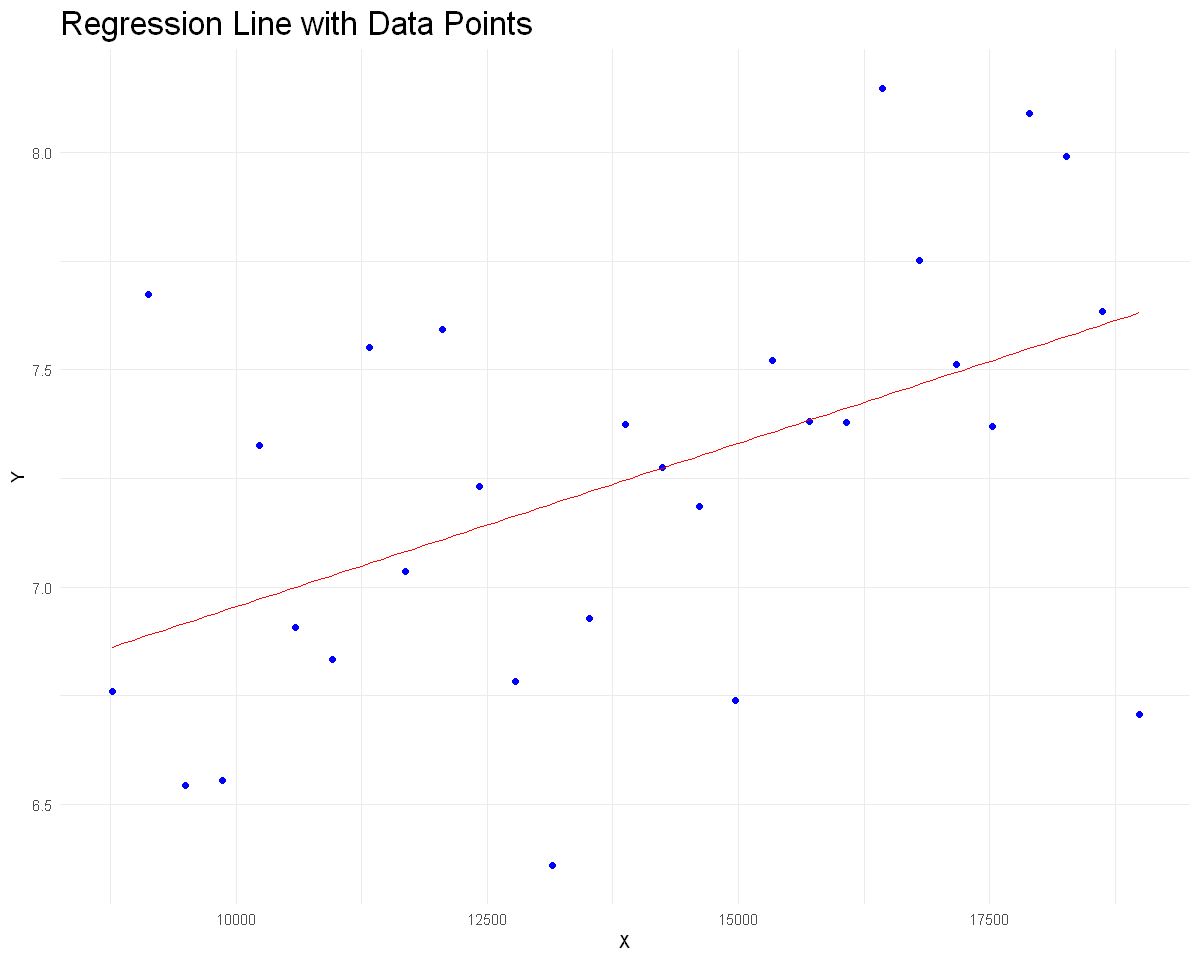

In [8]:
# Data
library(xts)
# Convert the data frame to an xts object
data_xts <- xts(df_AURONZO[, c("Max_Temperature", "Min_Temperature", "Mean_Temperature")], order.by = df_AURONZO$Date)

# Aggregate monthly mean data
ep3 <- endpoints(data_xts, on = "years")
yearly_mean <- period.apply(data_xts, INDEX = ep3, FUN = colMeans)


Y <- coredata(yearly_mean$Mean_Temperature)
X <- as.numeric(index(yearly_mean))

data_fit <- list(Y = Y, X = X, N = length(Y))

# Define the model
model_string <-
function(){
  for (i in 1:N) {
    Y[i,] ~ dnorm(Z[i], c)
    Z[i] <- a + b * X[i]
  }
  a ~ dunif(1, 20)
  b ~ dunif(-1, 3)
  c ~ dunif(0.001, 10)
}

init_values <- function(){
    list(a=runif(1,1,20), b=runif(1,-1,3), c=runif(1,0.001,10))
}

# Run the JAGS model
jags_linear_fit <- jags(data = data_fit, 
                 inits = init_values,
                 parameters.to.save = c("a", "b", "c"), 
                 model.file = model_string, 
                 n.chains = 3, 
                 n.iter = 12000, 
                 n.burnin = 2000, 
                 n.thin = 10,
                 DIC = T)

# Print a summary of the posterior distributions
#print(jags_linear_fit)

# Extract posterior means
summary_results <- as.data.frame(jags_linear_fit$BUGSoutput$summary)
means <- summary_results[, "mean"]
print(means)
a_estimate <- means[1]
b_estimate <- means[2]
c_estimate <- means[3]


# Estract std
stds <- summary_results[, "sd"]
a_std <- stds[1]
b_std <- stds[2]
c_std <- stds[3]

# Stampa le medie e le deviazioni standard
print(paste("Estimated a: ", a_estimate, ", std: ", a_std))
print(paste("Estimated b: ", b_estimate, ", std: ", b_std))
print(paste("Estimated c: ", c_estimate, ", std: ", c_std))


# Create data frame for the regression line
line_data <- data.frame(
  X = seq(min(X), max(X), length.out = 100),
  Y = a_estimate + b_estimate * seq(min(X), max(X), length.out = 100)
)

options(repr.plot.width=10, repr.plot.height=8)
# Plot the data points and the regression line
ggplot() +
  geom_point(aes(x = X, y = Y), color = 'blue', data = data.frame(X = X, Y = Y)) +
  geom_line(data = line_data, aes(x = X, y = Y), color = 'red') +
  labs(title = "Regression Line with Data Points",
       x = "X",
       y = "Y") + 
theme_minimal() +
theme(plot.title = element_text(size =20 ))



## • perform the same analysis using a constant regression 


Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
"Unused variable "X" in data"


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 29
   Unobserved stochastic nodes: 2
   Total graph size: 36

Initializing model

[1]  7.244422  4.758420 40.003547
Estimated a: 7.244422 
Estimated c: 4.75842 


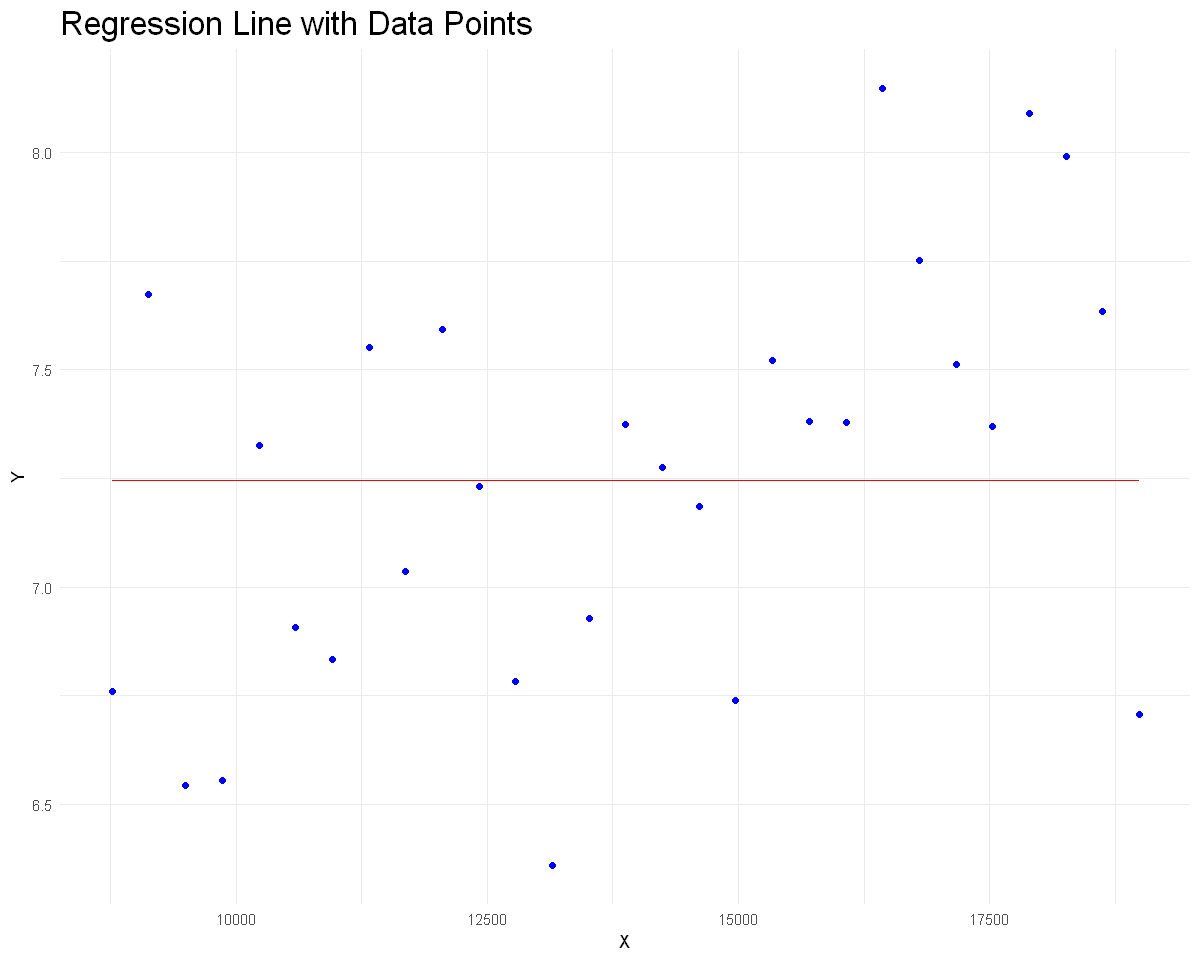

In [9]:
# Data
library(xts)
# Convert the data frame to an xts object
data_xts <- xts(df_AURONZO[, c("Max_Temperature", "Min_Temperature", "Mean_Temperature")], order.by = df_AURONZO$Date)

# Aggregate monthly mean data
ep3 <- endpoints(data_xts, on = "years")
yearly_mean <- period.apply(data_xts, INDEX = ep3, FUN = colMeans)


Y <- coredata(yearly_mean$Mean_Temperature)
X <- as.numeric(index(yearly_mean))

data_fit <- list(Y = Y, X = X, N = length(Y))

# Define the model
model_string <-
function(){
  for (i in 1:N) {
    Y[i,] ~ dnorm(Z[i], c)
    Z[i] <- a 
  }
  a ~ dunif(1, 20)
  c ~ dunif(0.001, 10)
}

init_values <- function(){
    list(a=runif(1,1,20), c=runif(1,0.001,10))
}

# Run the JAGS model
jags_constant_fit <- jags(data = data_fit, 
                 inits = init_values,
                 parameters.to.save = c("a", "c"), 
                 model.file = model_string, 
                 n.chains = 3, 
                 n.iter = 12000, 
                 n.burnin = 2000, 
                 n.thin = 10,
                 DIC = T)

# Print a summary of the posterior distributions
#print(jags_fit)

# Extract posterior means
summary_results <- as.data.frame(jags_constant_fit$BUGSoutput$summary)
means <- summary_results[, "mean"]
print(means)
a_estimate <- means[1]
c_estimate <- means[2]

# Print estimated parameters
cat("Estimated a:", a_estimate, "\n")
cat("Estimated c:", c_estimate, "\n")

# Create data frame for the regression line
line_data <- data.frame(
  X = seq(min(X), max(X), length.out = 100),
  Y = a_estimate
)

# Plot the data points and the regression line
options(repr.plot.width=10, repr.plot.height=8)
ggplot() +
  geom_point(aes(x = X, y = Y), color = 'blue', data = data.frame(X = X, Y = Y)) +
  geom_line(data = line_data, aes(x = X, y = Y), color = 'red') +
  labs(title = "Regression Line with Data Points",
       x = "X",
       y = "Y") +
theme_minimal() +
theme(plot.title = element_text(size =20 ))

## • perform a Bayesian hypothesis test comparing the two results 


In [10]:
# Extract DIC values
dic_constant <- jags_constant_fit$BUGSoutput$DIC
dic_linear <- jags_linear_fit$BUGSoutput$DIC

# Print DIC values
cat("DIC for constant model:", dic_constant, "\n")
cat("DIC for linear model:", dic_linear, "\n")

# Compare DIC values
if (dic_constant < dic_linear) {
  cat("The constant model is preferred.\n")
} else {
  cat("The linear model is preferred.\n")
}


DIC for constant model: 42.00631 
DIC for linear model: 36.20785 
The linear model is preferred.


Here we used the DIC to compare the two models for the hypotesis test to see which model fits better the data. We observe that the linear fit fits better the data and the slope is positive, so the trend of the mean temperature is rising over the years.

In [11]:
#maybe explain something about DIC..(vogliamo fare un altro hp test?o va bene questo? maybe bayes factor?)

## • do you see correlations between data measured at different stations ? 

For the sake of not reindexing all the time series we choose not to compare Castelfranco veneto as we do not have the same data as the other ones. \
We then choose to compare only the mean temperatures, the same analysis could be done for max and min but it's redundant. \
We calculated the rolling correlation as we have a time series.


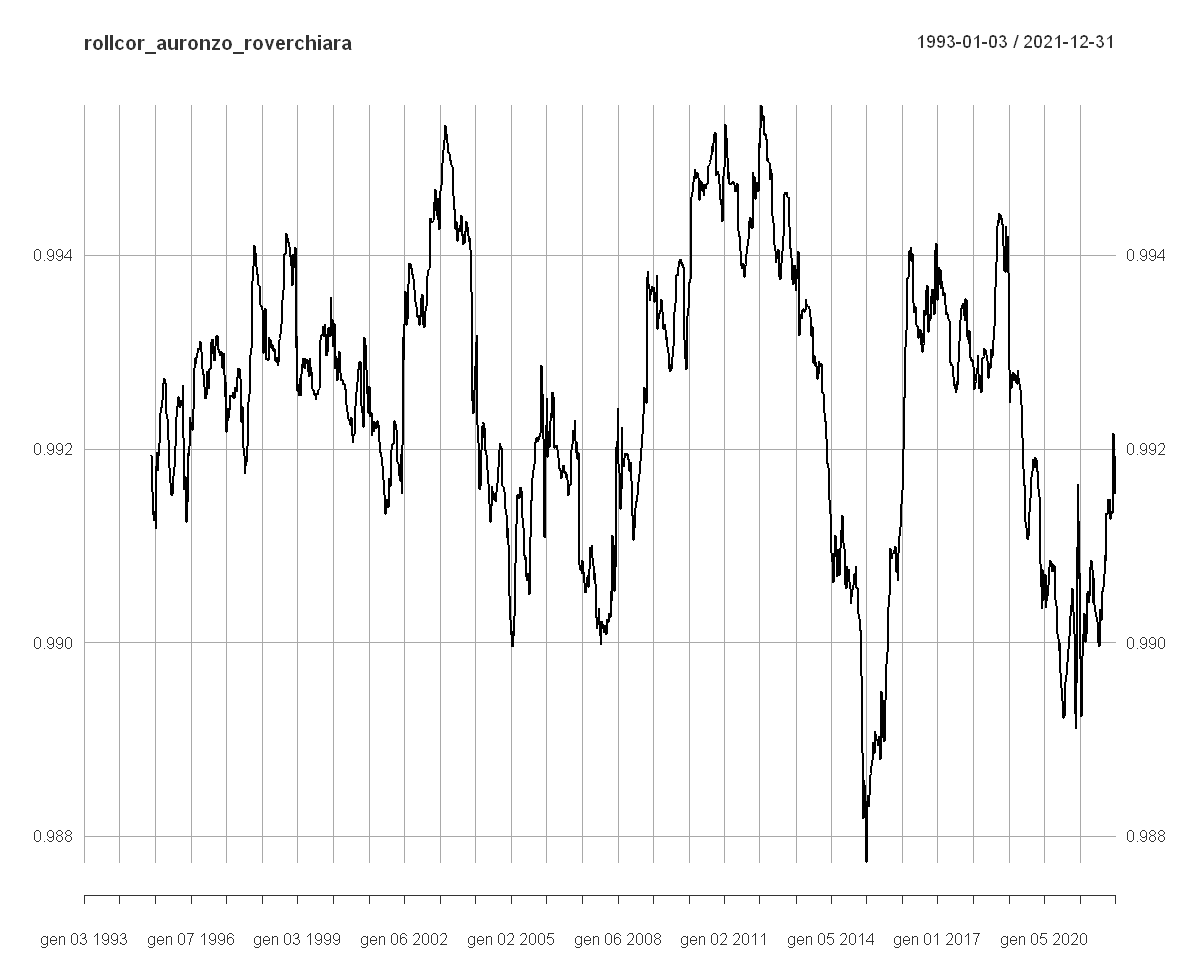

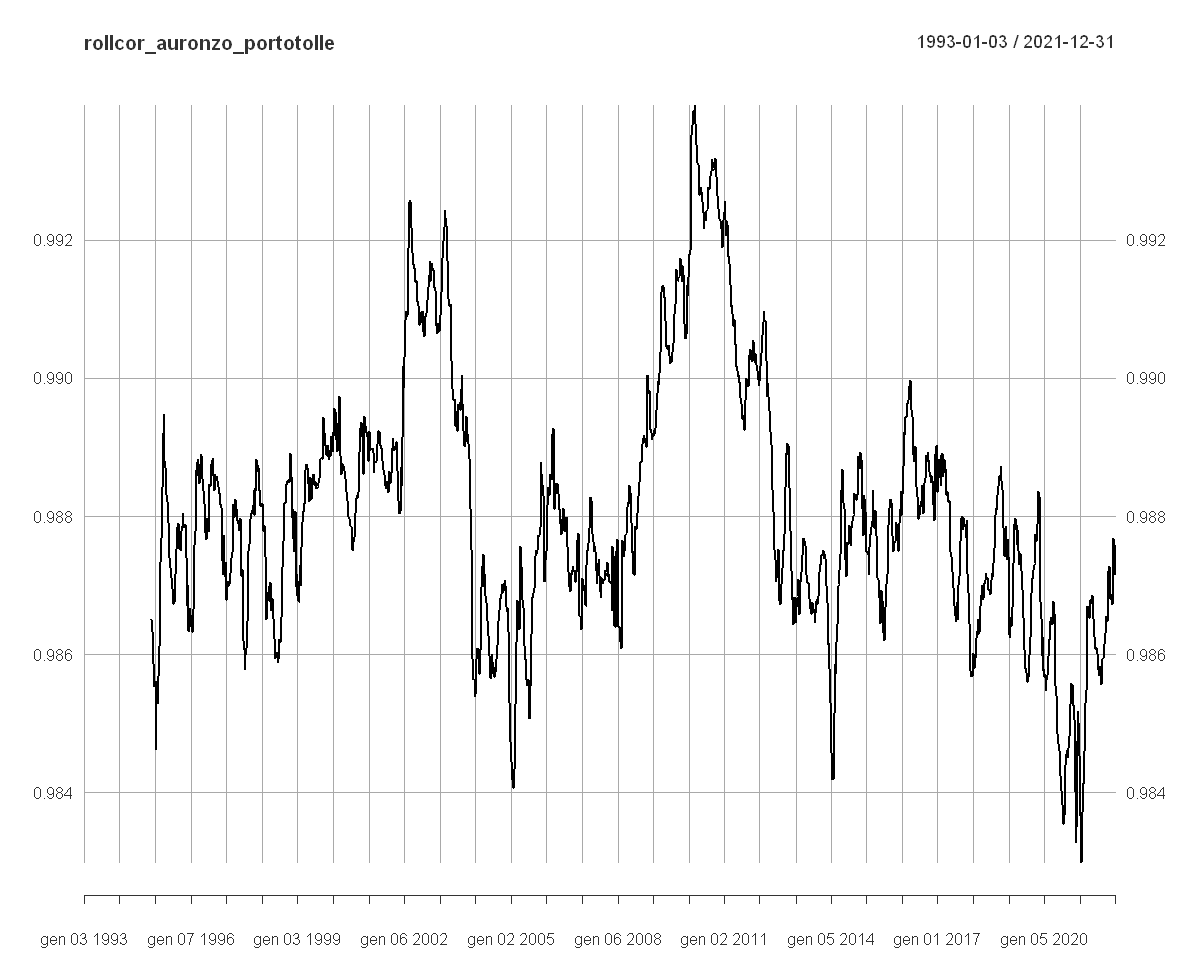

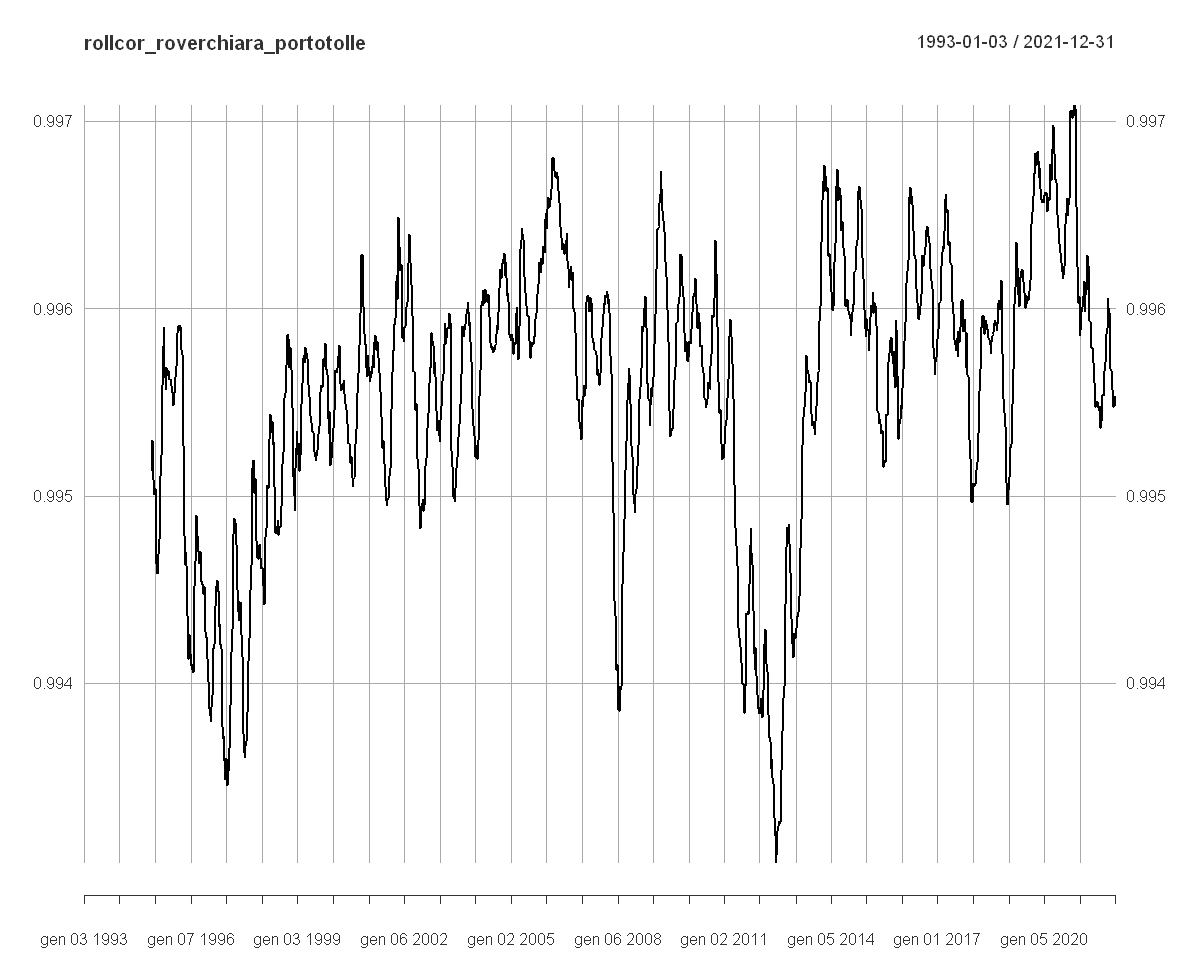

In [12]:
# export all the station data in xts format
library(xts)
portotolle_xts <- xts(df_PORTOTOLLE[, c("Max_Temperature", "Min_Temperature", "Mean_Temperature")], 
                      order.by = df_PORTOTOLLE$Date)
roverchiara_xts <- xts(df_ROVERCHIARA[, c("Max_Temperature", "Min_Temperature", "Mean_Temperature")], 
                      order.by = df_ROVERCHIARA$Date)
auronzo_xts <- xts(df_AURONZO[, c("Max_Temperature", "Min_Temperature", "Mean_Temperature")], 
                      order.by = df_AURONZO$Date)


ep_portotolle <- endpoints(portotolle_xts, on = "weeks")
yearly_mean_portotolle <- period.apply(portotolle_xts, INDEX = ep_portotolle, FUN = colMeans)

ep_roverchiara <- endpoints(roverchiara_xts, on = "weeks")
yearly_mean_roverchiara <- period.apply(roverchiara_xts, INDEX = ep_roverchiara, FUN = colMeans)

ep_auronzo <- endpoints(auronzo_xts, on = "weeks")
yearly_mean_auronzo <- period.apply(auronzo_xts, INDEX = ep_auronzo, FUN = colMeans)

# Combine Mean_Temperature of each station into one xts object
compare_xts <- merge(
  yearly_mean_portotolle[,"Mean_Temperature"], 
  yearly_mean_roverchiara[,"Mean_Temperature"], 
  yearly_mean_auronzo[,"Mean_Temperature"],
  all = TRUE
)

window <- 100
options(repr.plot.width=10, repr.plot.height=8)
rollcor_auronzo_roverchiara = rollapply(compare_xts, window, function(x) cor(x[ , 3],x[ , 2]), by.column=FALSE) #auronzo vs roverchiara means
plot(rollcor_auronzo_roverchiara)
rollcor_auronzo_portotolle = rollapply(compare_xts, window, function(x) cor(x[ , 3],x[ , 1]), by.column=FALSE)
plot(rollcor_auronzo_portotolle)
rollcor_roverchiara_portotolle = rollapply(compare_xts, window, function(x) cor(x[ , 2],x[ , 1]), by.column=FALSE)
plot(rollcor_roverchiara_portotolle)

As we can see the data from the 3 stations is highly correlated, we could do an analysis of the correlation of the monthly or yearly means but it's the same thing. Of course we expected a very high correlation between the dataset because we are comparing the same types of data for cities in Veneto (very near to each other).

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


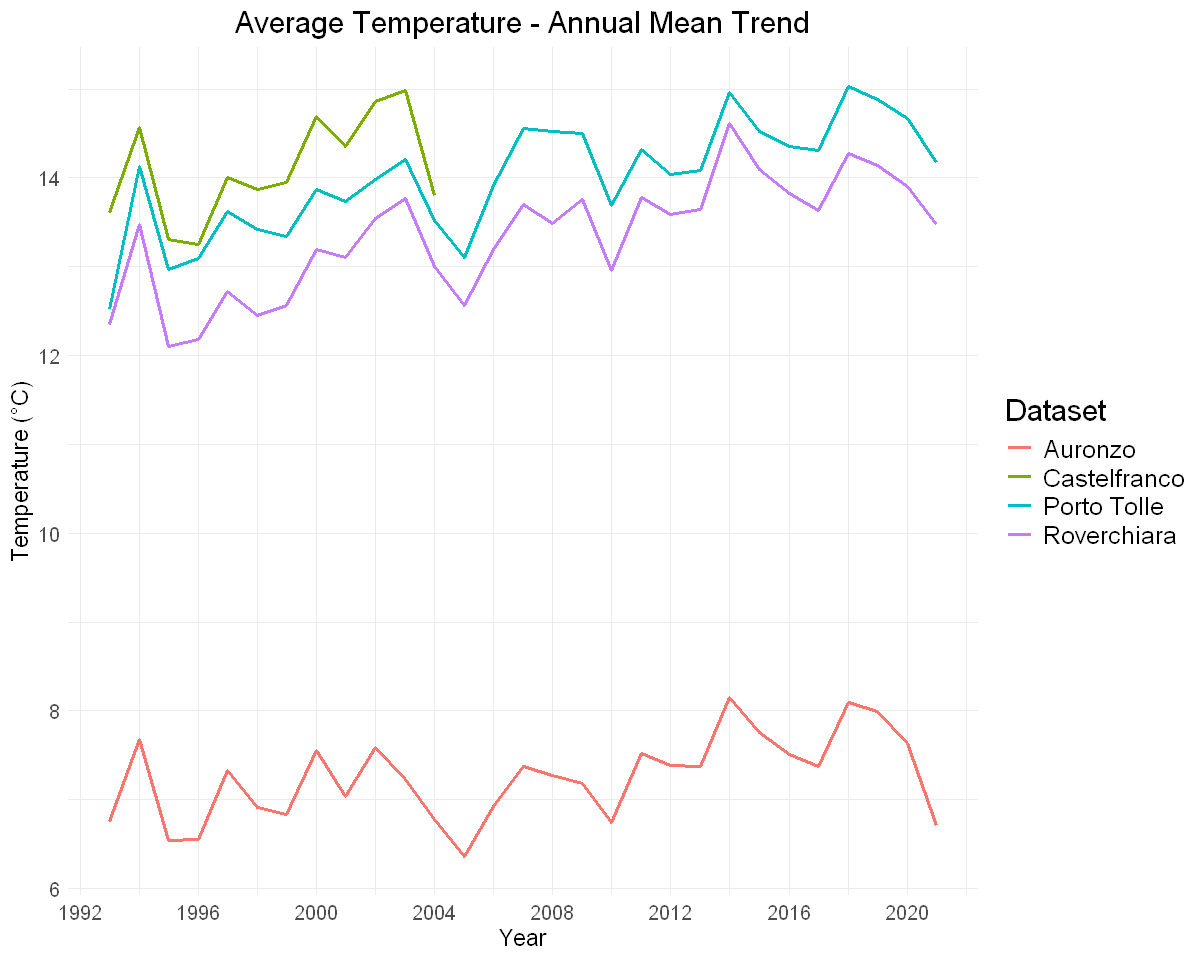

In [13]:
#Combine the data: Make sure both datasets have the same structure and combine them into a single data frame.
#Plot the combined data: Use ggplot2 to plot both datasets, distinguishing them by color or linetype

# Combine both datasets
df_combined <- rbind(
  data.frame(Year = df2$Year, Mean_Average_Temperature =df2$Mean_Average_Temperature, Dataset = "Porto Tolle"),
  data.frame(Year = df4$Year, Mean_Average_Temperature = df4$Mean_Average_Temperature, Dataset = "Roverchiara"),
  data.frame(Year = df6$Year, Mean_Average_Temperature = df6$Mean_Average_Temperature, Dataset = "Castelfranco"),
  data.frame(Year = df8$Year, Mean_Average_Temperature = df8$Mean_Average_Temperature, Dataset = "Auronzo")
)

options(repr.plot.width=10, repr.plot.height=8)
# Plot using ggplot2
ggplot(df_combined, aes(x = Year, y = Mean_Average_Temperature, color = Dataset)) +
  geom_line(size = 1) +
  labs(title = "Average Temperature - Annual Mean Trend",
       x = "Year",
       y = "Temperature (°C)",
       color = "Dataset") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 18, hjust = 0.5),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    legend.title = element_text(size = 18), 
    legend.text = element_text(size = 15)
  ) +
scale_x_continuous(n.breaks = 10)# Adjust the 'by' argument to control label frequency



We can see from the shape of the lines of the means year over the years (1993-2021) than the pattern for the Temperature variation is the same for all the cities and unless for Auronzo , which is in the mountains, the temperatures are quite similar (indeed the cities are less than 200km distant from each other)

# Part 2:
## Analysis of the evolution of the annual difference of the min, max and daily average temperature over time (1993 - 2021):

## - assuming you found an increasing trend in the temperature, compute it considering 4-years intervals and compare the results with those shown in SNPA (Sistema Nazionale per la Protezione Ambiente) in [1].


## - perform an analysis using a Bayesian linear regression with JAGS or STAN

As observed in the previous graphs, there is a clear increase in temperature over the years. We have created charts to illustrate the anomalies (the residuals) of the annual average temperature. An anomaly is defined as the difference between the recorded values for a given year and the long-term average value(the mean temperature from 1993 to 2021).
This study has been evaluated with of course min/max and mean data for the temperature.
This study is usuful to make comparison with SNPA data.

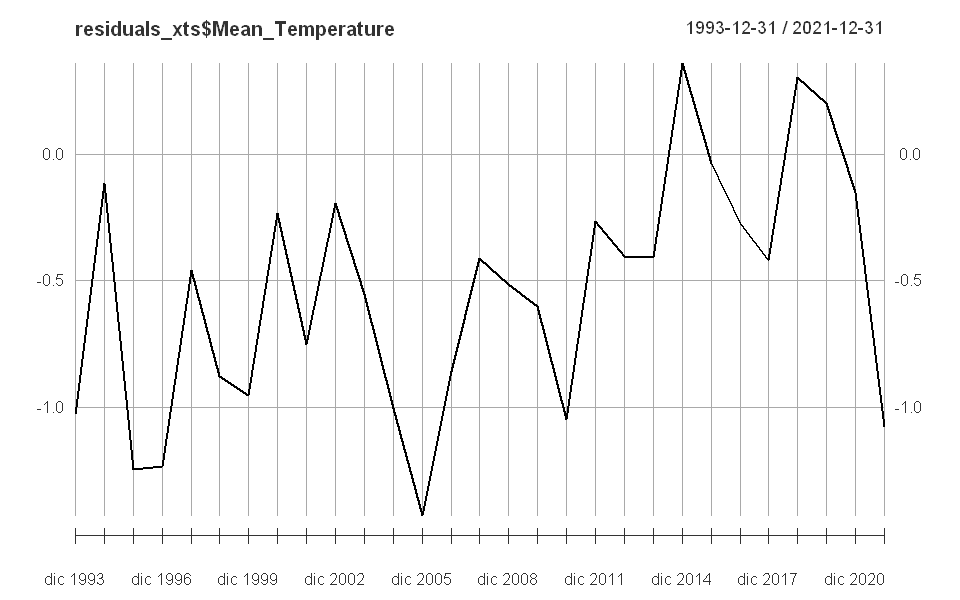

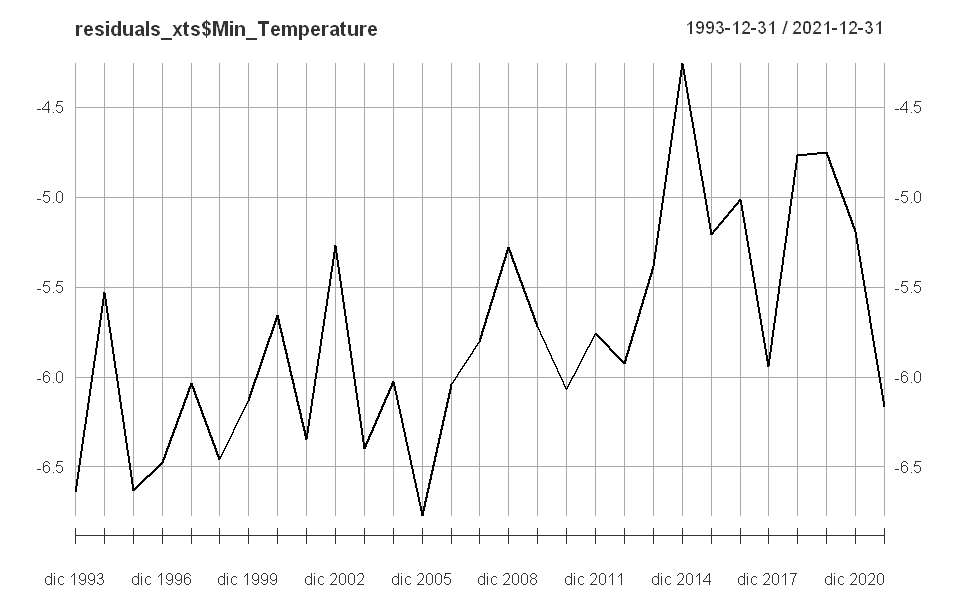

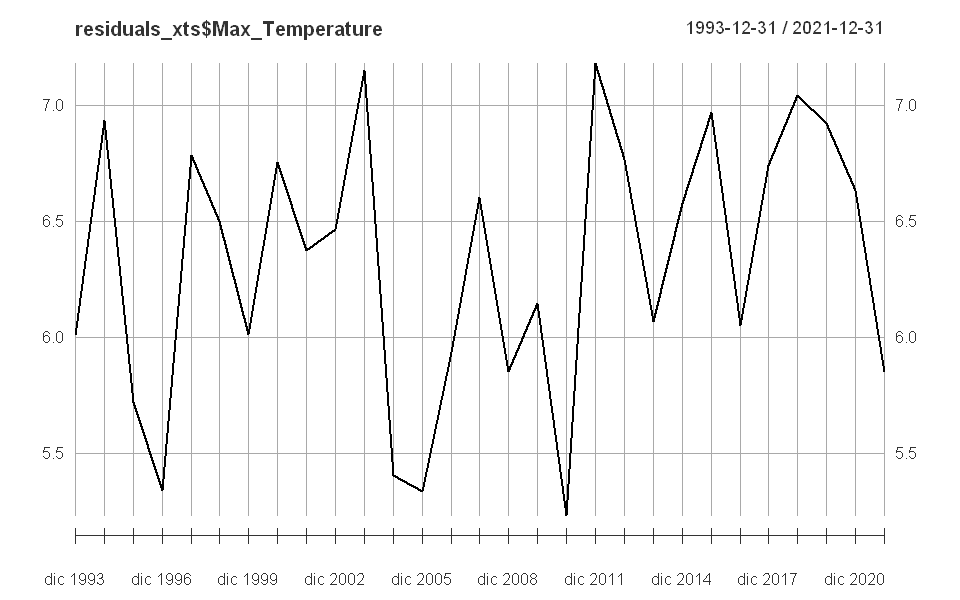

In [14]:
# Function to calculate annual residuals
calculate_residuals <- function(data_xts) {
  # Calculate endpoints for each year
  ep <- endpoints(data_xts, on = "years")
  mean_xts <- period.apply(data_xts, INDEX = ep, FUN = colMeans)
  residuals_xts <- mean_xts - mean(mean_xts)
  plot(residuals_xts$Mean_Temperature, main = "Annual Residuals of Mean Temperature",
       xlab = "Year", ylab = "Residuals", type = "l")
  return(residuals_xts)
}

options(repr.plot.width=8, repr.plot.height=5)

# Example usage
data_xts <- auronzo_xts  # Replace with your xts object
residuals_xts <- calculate_residuals(data_xts)
plot(residuals_xts$Mean_Temperature)
plot(residuals_xts$Min_Temperature)
plot(residuals_xts$Max_Temperature)

### comparison with SNPA

 https://www.snpambiente.it/wp-content/uploads/2021/06/Rapporto-SNPA-21_2021.pdf

https://www.isprambiente.gov.it/files/pubblicazioni/statoambiente/SA_58_15.pdf

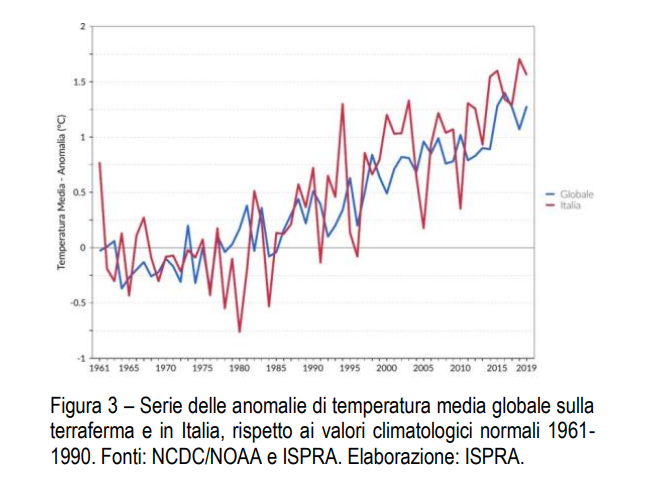

In [15]:
library("IRdisplay")
display_png(file="snpa2.png" ,width = 500)

We can see that the trend in this graph is the same as in the previous ones calculated with our data. 
It is not very meaningful to make a quantitative comparison with the SNPA results because we have many differences in the two analyses: \
1- their dataset is much larger as they have many more years available \
2- they have used many more geographical locations \
3- they have used more sophisticated models for the analysis. \
In any case, qualitatively, a similar trend can be observed in the graphs. \
However,  to provide some numbers, we report that the SNPA found that the increase in average temperature from 1981 to 2019 is $ \Delta T_{averageSNPA} =  0.38 \pm   0.05 \frac{°C}{10Y}$ 

In [16]:
Estimated_b <-0.000153053327553804*10*365
std<- 2.48951550119179e-05*10*365
#print(Estimated_b)
#print(std)

From the linear fit with JAGS we obtained:
- $ \Delta T_{average} =  0.56 \pm   0.09  \frac{°C}{10Y}$ 


Are the two results compatible?

In [17]:
# Given values
mean1 <- 0.38
mean2 <- 0.56
sd1 <- 0.5
sd2 <- 0.09
n1 <- 28
n2 <- 58

# Calculate the t-statistic
t_stat <- (mean1 - mean2) / sqrt((sd1^2 / n1) + (sd2^2 / n2))

# Degrees of freedom
df <- n1 + n2 - 2

# Calculate the p-value
p_value <- 2 * pt(-abs(t_stat), df)

# Print results
cat("t-statistic:", t_stat, "\n")
cat("p-value:", p_value, "\n")
#If the p-value is greater than 0.05, you can conclude that the two means are compatible.
#If the p-value is less than 0.05, you would reject the null hypothesis, suggesting the means are significantly different.

t-statistic: -1.890216 
p-value: 0.0621777 


So the two results are compatible. 
CONTROLLA

Here we have done another graphcs that show how the temperature is increasing over the years 1993-2021( by groups of 5Y for easier visualization) with a monthly view.


######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', exclude = 'lag') to your .Rprofile to stop           #
# dplyr from breaking base R's lag() function.                                #
#                                                                             #
# Code in packages is not affected. It's protected by R's namespace mechanism #
# Set `options(xts.warn_dplyr_breaks_lag = FALSE)` to suppress this warning.  #
#                                      

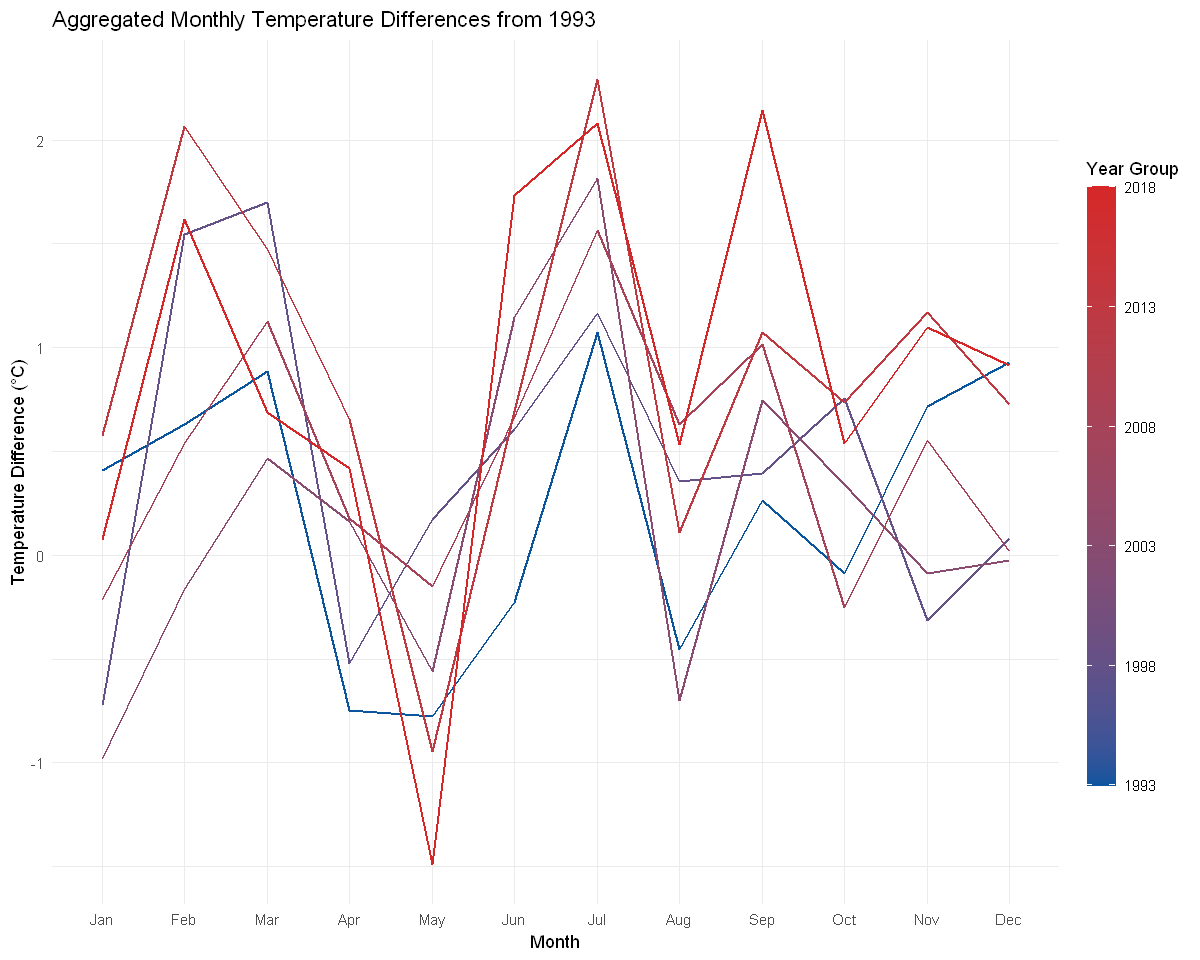

In [18]:
# Load necessary packages
library(ggplot2)
library(dplyr)
options(repr.plot.width=10, repr.plot.height=8)

# Assuming your data is in the data frame 'df1'
data <- df7

# Ensure that the Year column is treated as numeric
data$Year <- as.numeric(data$Year)

# Ensure the Month column is a factor with month abbreviations
data$Month <- factor(data$Month, levels = 1:12, labels = month.abb)

# Find the first year in the dataset
first_year <- min(data$Year)

# Calculate the mean temperatures for the first year
mean_temp_first_year <- data %>%
  filter(Year == first_year) %>%
  select(Month, Mean_avg_temp_month) %>%
  rename(Mean_temp_first_year = Mean_avg_temp_month)

# Join the mean temperatures of the first year back to the original dataframe
data <- data %>%
  left_join(mean_temp_first_year, by = "Month") %>%
  mutate(mean_temp_difference_from_1993 = Mean_avg_temp_month - Mean_temp_first_year)

# Create a new column to group years into two-year periods
data <- data %>%
  mutate(Year_group = floor((Year - first_year) / 5) * 5
         + first_year)

# Aggregate the data to calculate the mean temperature difference for each two-year period
aggregated_data <- data %>%
  group_by(Year_group, Month) %>%
  summarise(mean_temp_difference = mean(mean_temp_difference_from_1993, na.rm = TRUE)) %>%
  ungroup()

# Create the new plot with the aggregated mean temperature difference
p_agg <- ggplot(aggregated_data, aes(x = Month, y = mean_temp_difference, group = Year_group, color = Year_group)) +
  geom_line(alpha = 1.4, linewidth=0.8) +
  scale_color_gradient(
    low = "#0b559f", 
    high = "#d62728",
    breaks = seq(min(aggregated_data$Year_group), max(aggregated_data$Year_group), by = 5),  # Adjust the sequence as needed
    labels = seq(min(aggregated_data$Year_group), max(aggregated_data$Year_group), by = 5)   # Adjust the sequence as needed
  ) +  # Use scale_color_gradient for custom gradient
  labs(title = "Aggregated Monthly Temperature Differences from 1993",
       x = "Month",
       y = "Temperature Difference (°C)",
       color = "Year Group") +
  theme_minimal() +
  theme(
    legend.position = "right",  # Position legend on the right
    legend.key.height = unit(0.15, 'npc')  # Make legend bar as tall as the graph
  )

# Display the new non-interactive plot
print(p_agg)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 28
   Unobserved stochastic nodes: 4
   Total graph size: 125

Initializing model

[1]  2.837891e-01 -2.025904e-05  3.323745e+00  4.745071e+01
Estimated a: 0.2837891 
Estimated b: -2.025904e-05 
Estimated c: 3.323745 


Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_point()`)."


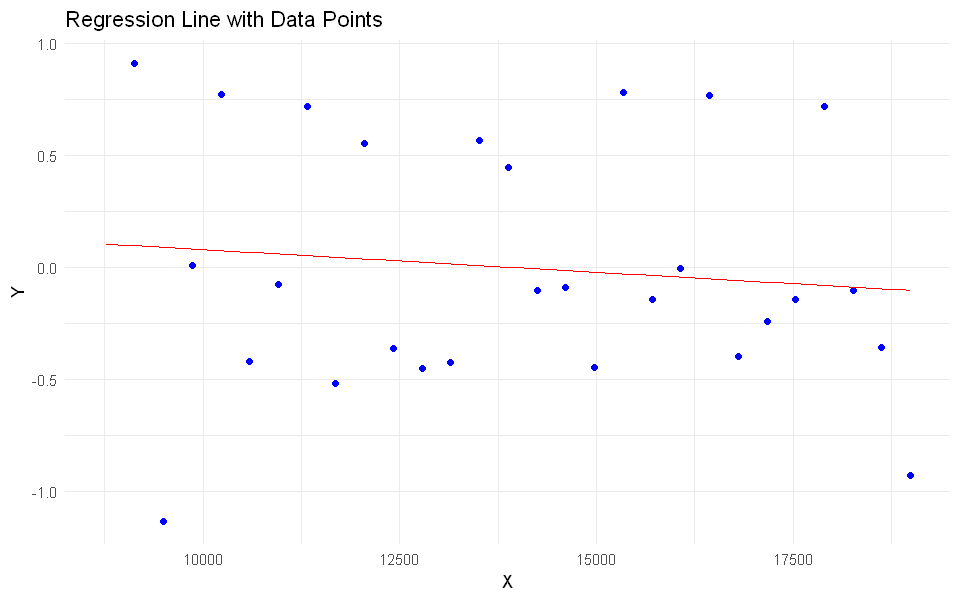

In [19]:
# Data
library(xts)
# Convert the data frame to an xts object
data_xts <- auronzo_xts

ep <- endpoints(data_xts, on = "years")
mean_xts <- period.apply(data_xts, INDEX = ep, FUN = colMeans)

# Calculate the difference of the mean temperature at lag 1
diff_data <- diff(mean_xts$Mean_Temperature, lag=1)

Y <- coredata(diff_data)
X <- as.numeric(index(diff_data))

data_fit <- list(Y = Y, X = X, N = length(Y))

# Define the model
model_string <-
function(){
  for (i in 1:N) {
    Y[i,] ~ dnorm(Z[i], c)
    Z[i] <- a + b * X[i]
  }
  a ~ dunif(-5, 5)
  b ~ dunif(-1, 1)
  c ~ dunif(0.001, 5)
}

init_values <- function(){
    list(a=runif(1,-5,5), b=runif(1,-1,1), c=runif(1,0.001,5))
}

# Run the JAGS model
jags_linear_fit <- jags(data = data_fit, 
                 inits = init_values,
                 parameters.to.save = c("a", "b", "c"), 
                 model.file = model_string, 
                 n.chains = 3, 
                 n.iter = 12000, 
                 n.burnin = 2000, 
                 n.thin = 10,
                 DIC = T)

# Print a summary of the posterior distributions
#print(jags_fit)

# Extract posterior means
summary_results <- as.data.frame(jags_linear_fit$BUGSoutput$summary)
means <- summary_results[, "mean"]
print(means)
a_estimate <- means[1]
b_estimate <- means[2]
c_estimate <- means[3]

# Print estimated parameters
cat("Estimated a:", a_estimate, "\n")
cat("Estimated b:", b_estimate, "\n")
cat("Estimated c:", c_estimate, "\n")

# Create data frame for the regression line
line_data <- data.frame(
  X = seq(min(X), max(X), length.out = 100),
  Y = a_estimate + b_estimate * seq(min(X), max(X), length.out = 100)
)


options(repr.plot.width=8, repr.plot.height=5)
# Plot the data points and the regression line
ggplot() +
  geom_point(aes(x = X, y = Y), color = 'blue', data = data.frame(X = X, Y = Y)) +
  geom_line(data = line_data, aes(x = X, y = Y), color = 'red') +
  labs(title = "Regression Line with Data Points",
       x = "X",
       y = "Y")+
  theme_minimal() 


From this graph, which shows the year-to-year temperature differences, we can see that the increase in temperatures has been almost constant over the years, indicating that there has been no accelerated growth in temperature ( indeed is almost decelerating). This is compatible with what SNPA has forcasted in the report above.

# Part 3
## Using the forecast R package [2], which provides methods and tools for displaying and analysing univariate time series, analyze the data. The library contains also the ARIMA (Autoregressive Integrated Moving Average), which allows to perform the equivalent of a linear regression in time series, where data is not stationary. Analyze your data and try to predict the evolution in the next years (average the data over multiple years, if needed).

## Time series analysis
Now we proceed to analyze the time series, we will see how our data has a seasonal trend (quite literally the seasons) and we will try to identify the seasonality to improve the effectiveness of modeling our data to get a better fit. \
We start by plotting the raw time series as it is:
 - in the following graphs we can see the raw time series, we can clearly see a period we will analyze later, and we see that the daily data is very noisy.
 - we plotted the difference of the data at lag 1 to see better the noise that the daily variation produces

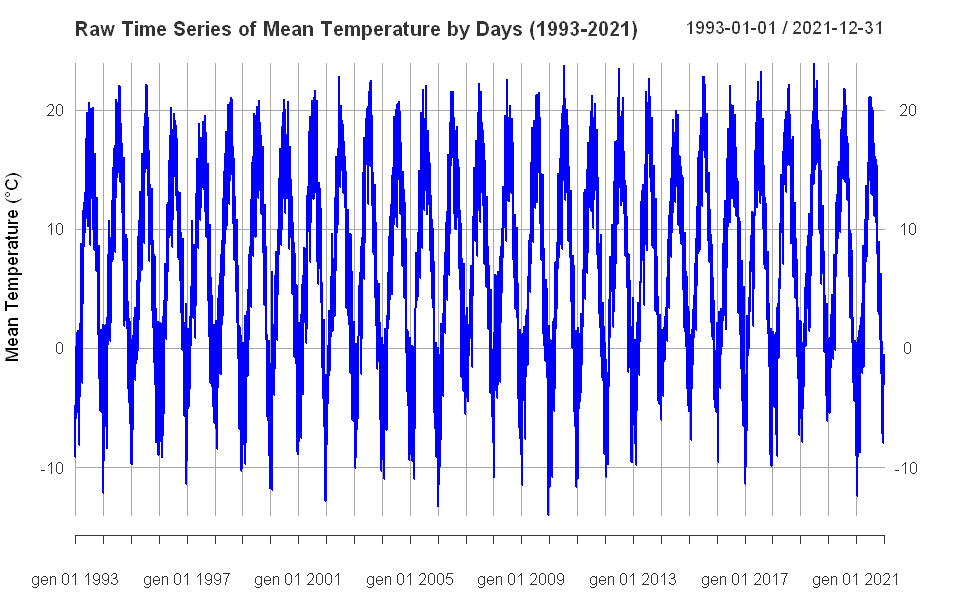

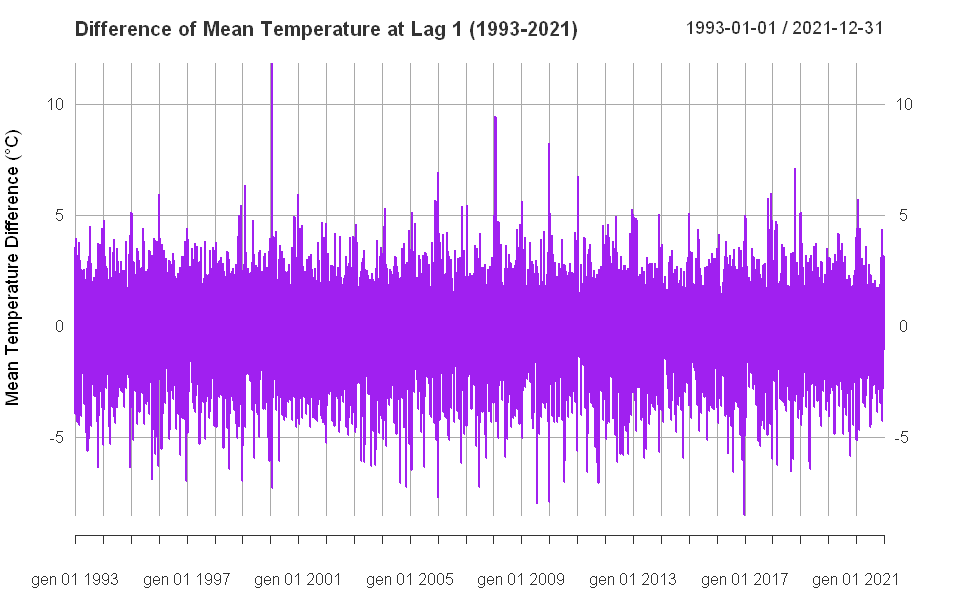

In [20]:
library(xts)
#xts is convenient for time series analysis and manipulation
data_xts <- xts(df_AURONZO[, c("Max_Temperature", "Min_Temperature", "Mean_Temperature")], order.by = df_AURONZO$Date)
plot(data_xts$Mean_Temperature, main = "Raw Time Series of Mean Temperature by Days (1993-2021)", ylab = "Mean Temperature (°C)", col = "blue")


# Calculate the difference of the mean temperature at lag 1
data_xts$Mean_Temperature_Diff <- diff(data_xts$Mean_Temperature, lag = 1)
plot.xts(data_xts$Mean_Temperature_Diff, main = "Difference of Mean Temperature at Lag 1 (1993-2021)", ylab = "Mean Temperature Difference (°C)", col = "purple")

We decided to plot ACF and PACF to see if there is a structure in the daily data but as we can see, daily temperatures are meaningfully correlated only up to 10 days. 

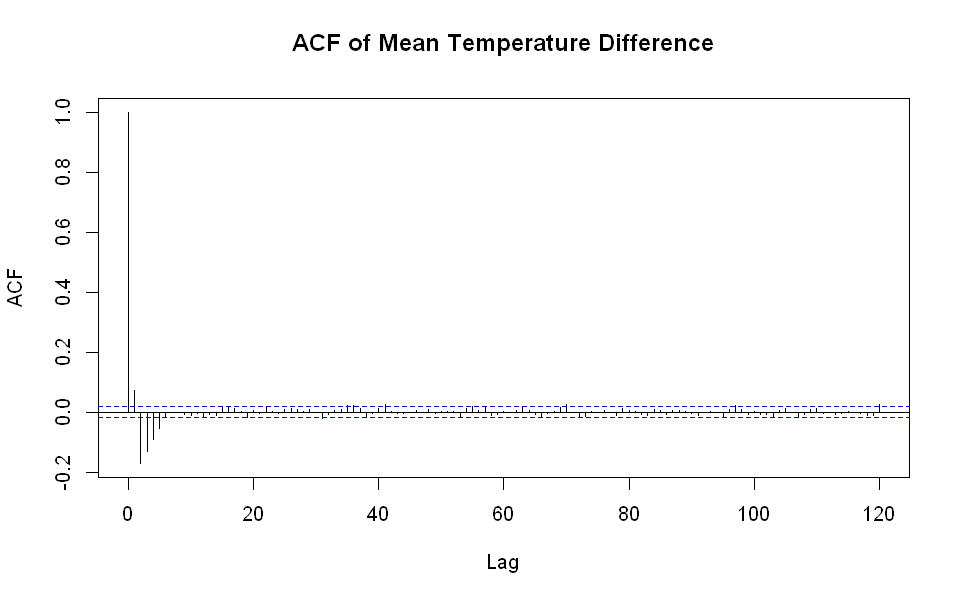

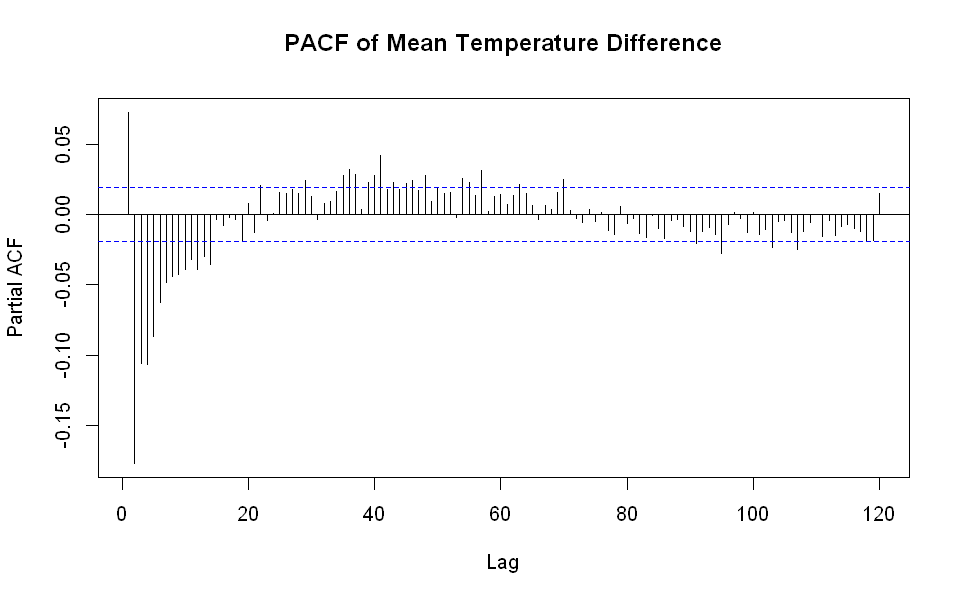

In [21]:
# Remove NA values from the calculated differences
mean_temp_diff <- na.omit(data_xts$Mean_Temperature_Diff)

# Plot ACF
acf(mean_temp_diff,  120, main = "ACF of Mean Temperature Difference")

# Plot PACF
pacf(mean_temp_diff, 120, main = "PACF of Mean Temperature Difference")

For this reason we could continue analyzing our data in its raw format but we would need to account for this noise too. \
A daily analysis of this variance could be done through the use of a GARCH model after the ARIMA one, but it's out of the scope of this project.

# Seasonal Analysis for mean month temperature

In this graph is shown how the temperature varies in the span of a year, showing the seasonality.

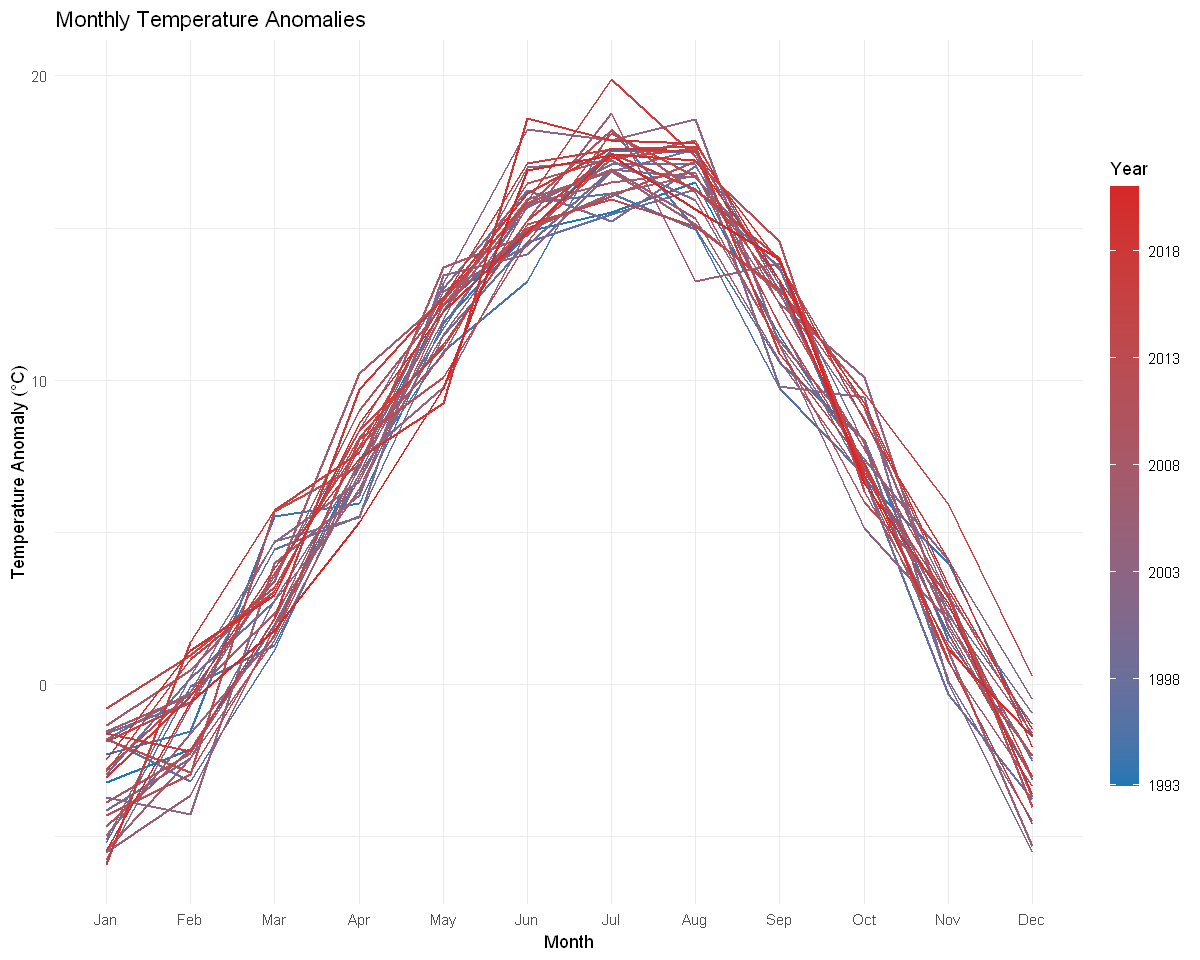

In [22]:
# Load necessary packages
library(ggplot2)
library(dplyr)

# Assuming your data is in the data frame 'df1'
data <- df7

data$Month <- factor(data$Month, levels = 1:12, labels = month.abb)
options(repr.plot.width=10, repr.plot.height=8)
# Create the plot with ggplot2
p <- ggplot(data, aes(x = Month, y = Mean_avg_temp_month, group = Year, color = Year)) +
  geom_line(alpha = 1.2, linewidth=0.6) +
  scale_color_gradient(
    low = "#1f77b4", 
    high = "#d62728",
    breaks = seq(min(data$Year), max(data$Year), by = 5),  # Adjust the sequence as needed
    labels = seq(min(data$Year), max(data$Year), by = 5)   # Adjust the sequence as needed
  ) +  # Use scale_color_gradient for custom gradient
  labs(title = "Monthly Temperature Anomalies",
       x = "Month",
       y = "Temperature Anomaly (°C)",
       color = "Year") +
  theme_minimal() +
  theme(
    legend.position = "right",  # Position legend on the right
    legend.key.height = unit(0.15, 'npc')  # Make legend bar as tall as the graph
  )

# Display the non-interactive plot
print(p)



We decided to aggregate our data to get rid of the daily noise, so we computed the averages over one month of our data to maintain seasonality. \
Below we can see the same plots we saw above but with the averages of the months:
 - now we clearly see the stagionality both in the plot and differences at lag 1 of the time series
 - analyzing the ACF and PACF, we see that the seasonality has period 12, as we expected every month is correlated higher with the same months of earlier years

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



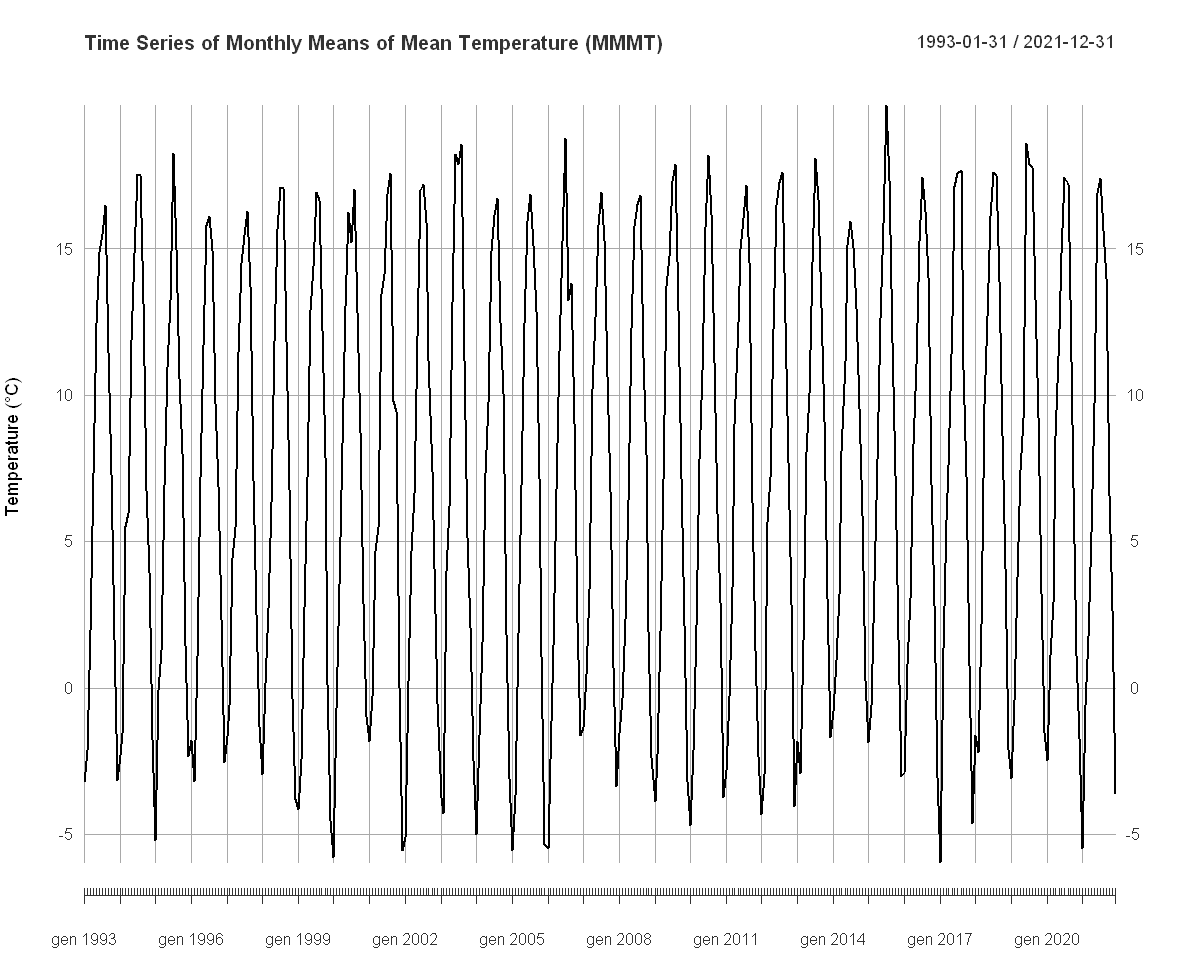

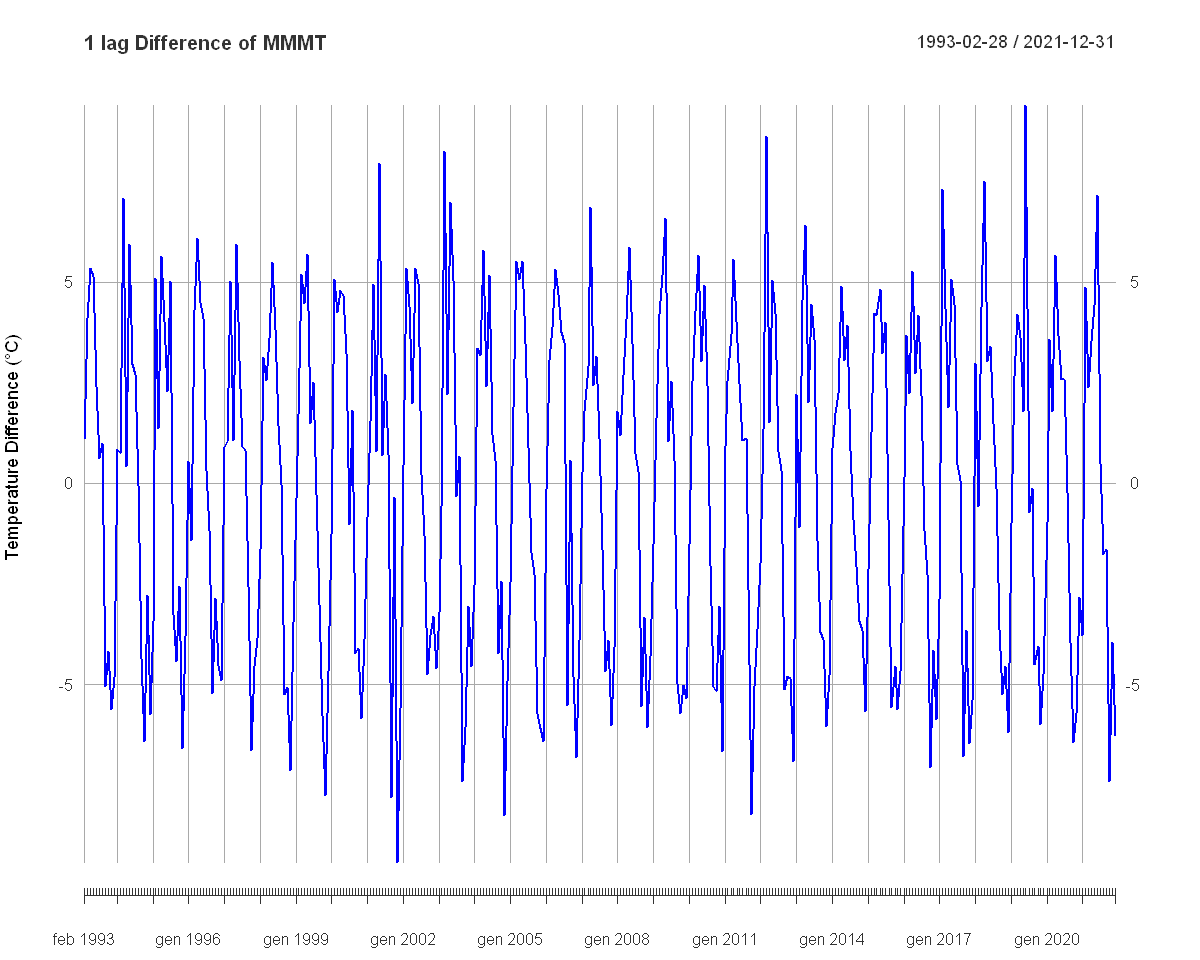

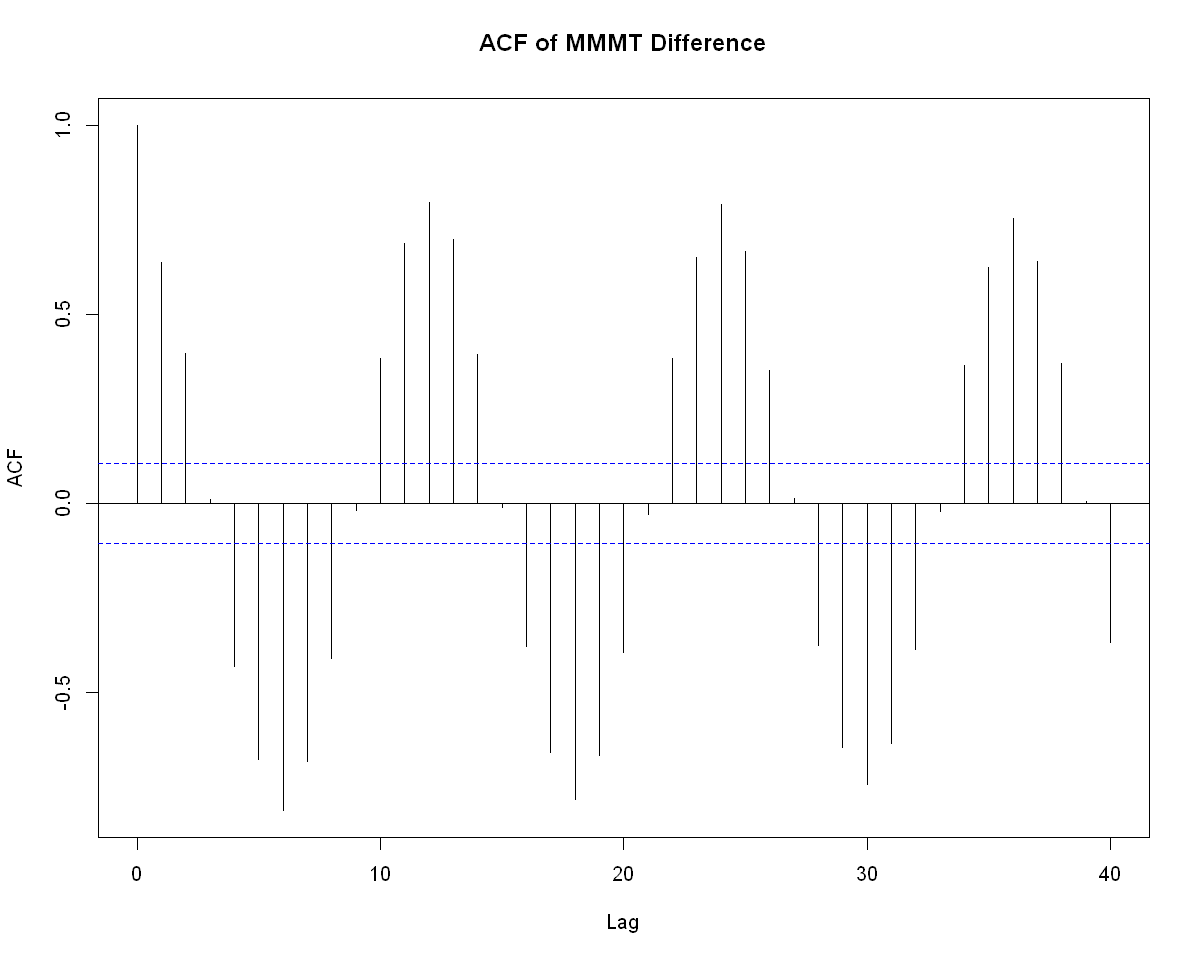

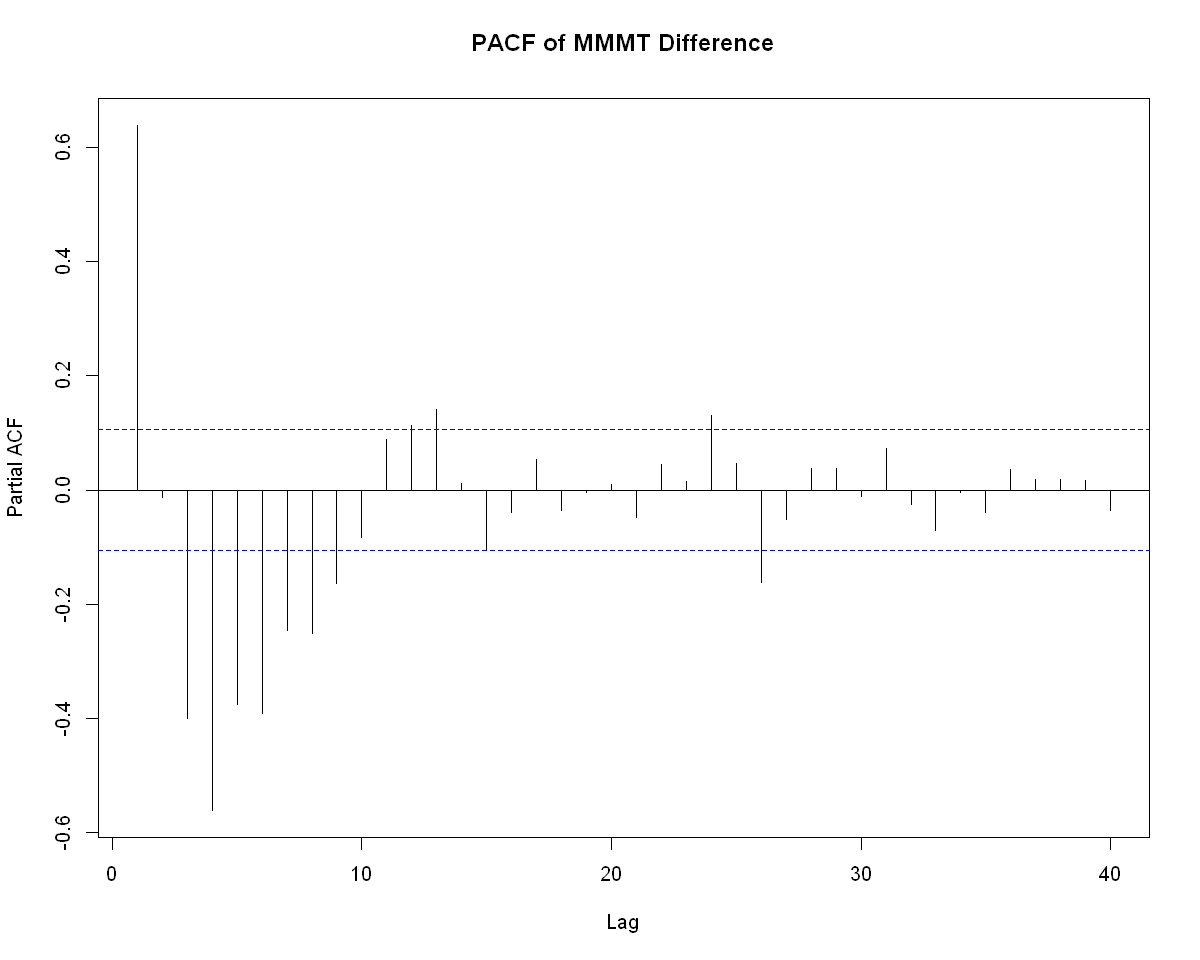

In [23]:
# Load necessary packages
library(forecast)

# Aggregate monthly mean data
ep2 <- endpoints(data_xts, on = "months")
monthly_mean <- period.apply(data_xts, INDEX = ep2, FUN = colMeans)

# Plot 1: Time Series as it is with xts
plot(monthly_mean$Mean_Temperature, main = "Time Series of Monthly Means of Mean Temperature (MMMT)", ylab = "Temperature (°C)")

# Plot 2: Difference 1
diff_data <- na.omit(diff(monthly_mean$Mean_Temperature))
plot(diff_data, main = "1 lag Difference of MMMT", ylab = "Temperature Difference (°C)",col = "blue")

# Plot 3: ACF
acf(diff_data, 40, main = "ACF of MMMT Difference")

# Plot 4: PACF
pacf(diff_data, 40, main = "PACF of MMMT Difference")


We now plot the difference of the difference of the same months of different years with the formula: $x_t - (x_{t-1}-x_{t-12})$. \
We can see from both the plot and its ACF and PACF that seasonality is almost gone, with some correlation left at period 12.

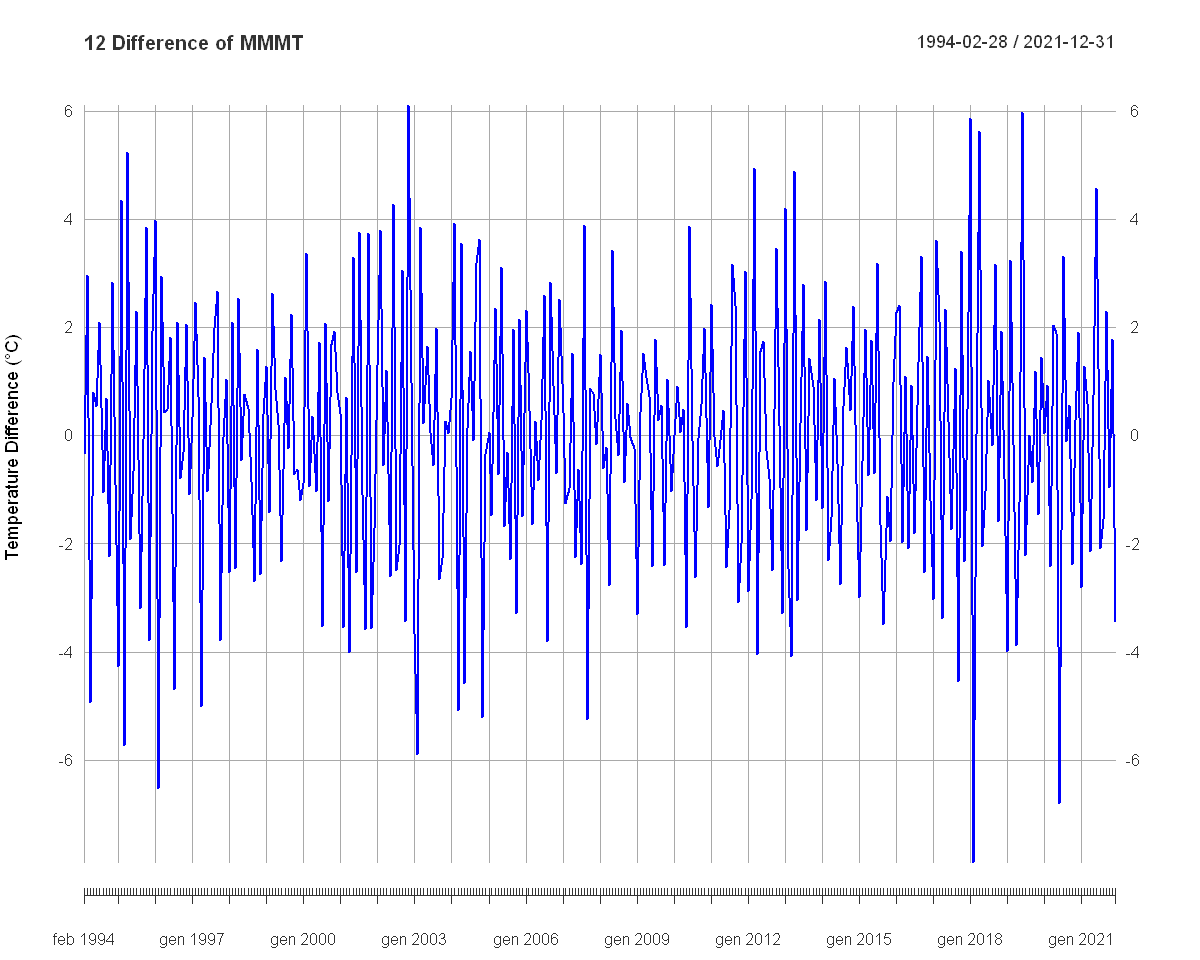

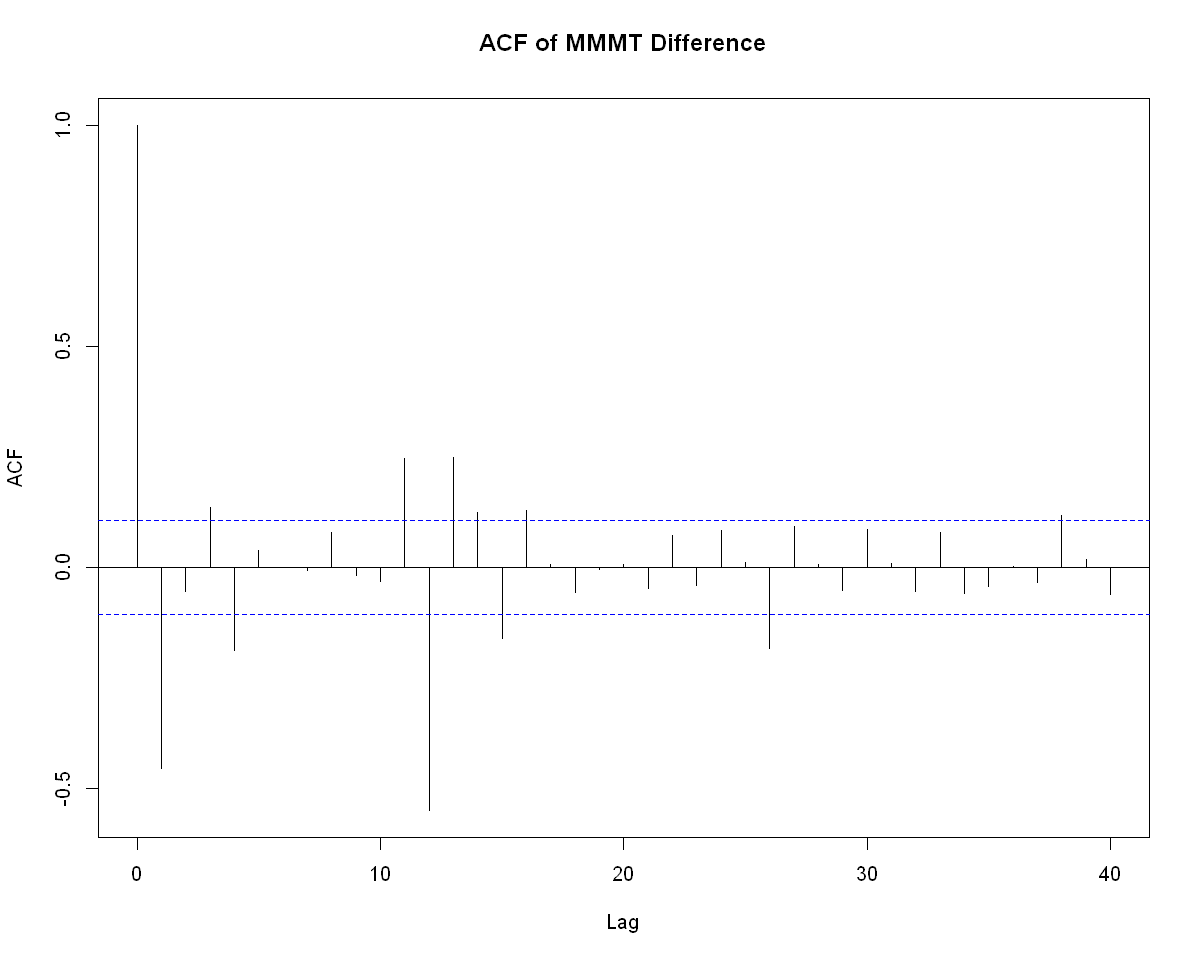

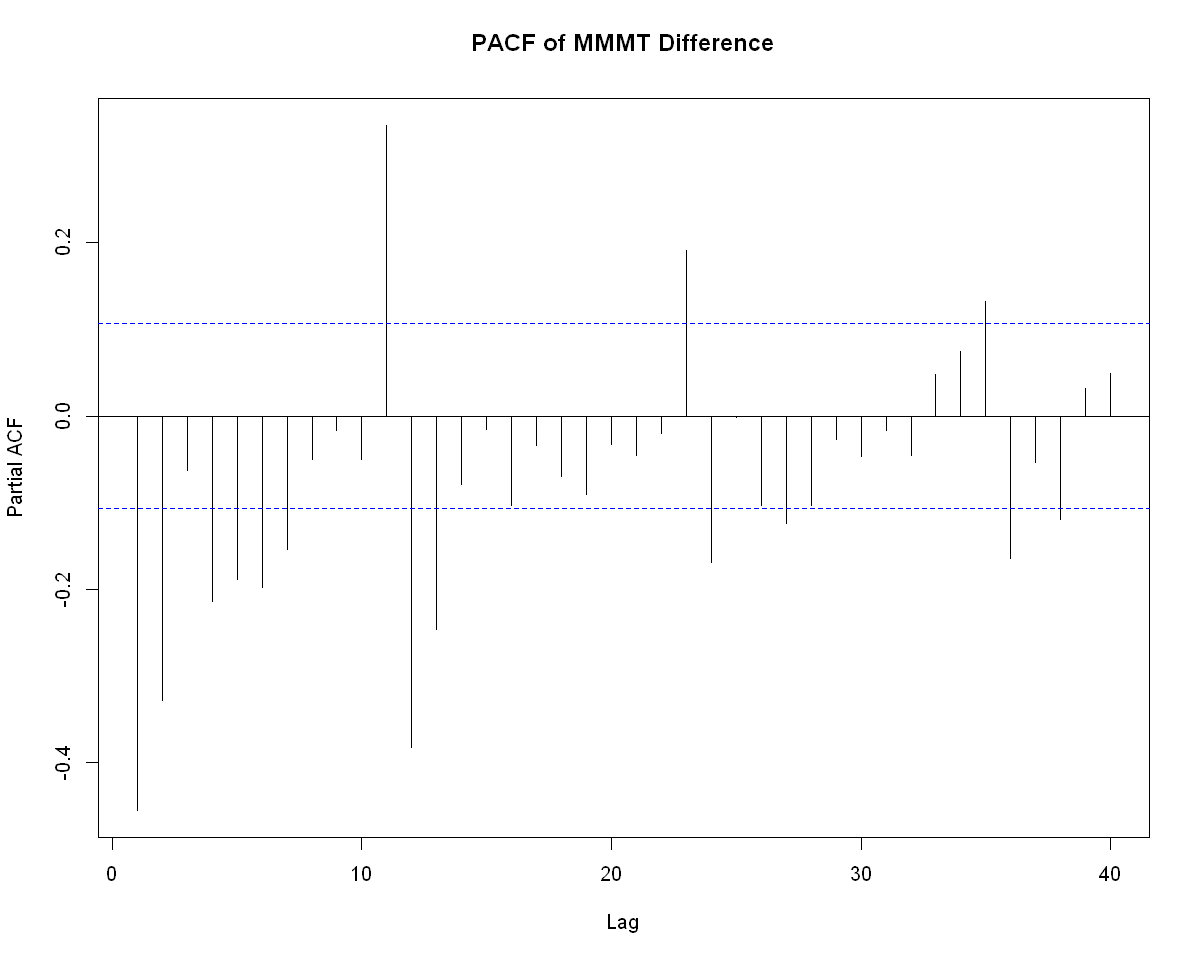

In [24]:
# Plot 2: Difference 1
diff_data_12 <- na.omit(diff(diff(monthly_mean$Mean_Temperature),12))
plot(diff_data_12, main = "12 Difference of MMMT", ylab = "Temperature Difference (°C)",col = "blue")

# Plot 3: ACF
acf(diff_data_12, 40, main = "ACF of MMMT Difference")

# Plot 4: PACF
pacf(diff_data_12, 40, main = "PACF of MMMT Difference")


With this information extrapulated from the time series we can train an ARIMA model to fit our data. \
For testing purposes we divided our data in train and test sets, leaving 4 out of the 28 years we have to test our model.

In [25]:
hist2 = function(val, n = 50, main = ""){
  hist(val, nclass = n, freq = F, main = main)
  curve(dnorm(x, mean = mean(val), sd = sqrt(var(val))),
        col = "cornflowerblue",
        add = T)
}

train.test = function(ts, ltest = 48, ltrain = length(ts)-ltest){
  t = length(ts)
  train = ts[(t-ltest-ltrain+1):(t-ltest)]
  test = ts[(t-ltest+1):t]
  
  df = list(train = train, test = test)
  
  return(df)
}
source("sse_v4.lib")

In [26]:
cast_time <- 48 #months
train_test_data <- train.test(monthly_mean$Mean_Temperature, ltest = cast_time)
#plot(train_test_data$train)

Our model takes the raw daily data and accounts itself for seasonality, effectively becoming a SARIMA model, as we found before the seasonality period is 12, the other good parameters we found for the train data dividend in this manner are: 
 - p=6 for AR, d=1 for I, q=2 for MA; 
 - p=1 for sAR, d=1 for sI, q=2 for sMA;

explain d,l and q :)


In [27]:
#here we have done SARIMA

# This works well with all the data
#fit1 <- Arima(train_test_data$train, order = c(6,1,2), include.mean = TRUE, seasonal = list(order = c(3,1,2), period = 12),  include.drift = F)

fit1 <- Arima(train_test_data$train, order = c(6,1,2), include.mean = TRUE, 
              seasonal = list(order = c(1,1,2), period = 12),  include.drift = F)

stat.mod(fit1)
BIC(fit1)

library(tseries)

jqtest <- jarque.bera.test(fit1$residuals)
print(jqtest)
#It means that the temperature this month depends on the temperature of the same month last year.


                                               
-------------- Stime dei parametri ----------- 
            Coef    Std.Err      tstat         pval
ar1  -0.67539175 0.15798313 -4.2750878 1.910619e-05
ar2   0.21162688 0.07998281  2.6459044 8.147285e-03
ar3   0.11607014 0.07418613  1.5645801 1.176814e-01
ar4  -0.12035476 0.07370634 -1.6328957 1.024909e-01
ar5  -0.12421661 0.07958412 -1.5608216 1.185658e-01
ar6  -0.03473095 0.06524605 -0.5323073 5.945132e-01
ma1  -0.12726599 0.14997628 -0.8485742 3.961183e-01
ma2  -0.85521090 0.15208157 -5.6233698 1.872679e-08
sar1 -0.40545050 1.72234375 -0.2354063 8.138934e-01
sma1 -0.61617129 1.74359673 -0.3533909 7.237954e-01
sma2 -0.38382867 1.74285017 -0.2202304 8.256917e-01
                                                
----------------------------------------------- 
    sigma2        AIC     loglik 
   1.58356 1005.94171 -490.97085 
                                               
-------------Test di Ljung-Box --------------- 
     statistic gdl

[1] 1049.855


	Jarque Bera Test

data:  fit1$residuals
X-squared = 0.27184, df = 2, p-value = 0.8729



Our model works well for all parameters, in particular we received a p-value of 0.99 for ljung-box test, which is a p-value we want to accept, so we want it closer to 1 as possible. \
Following we plot the residuals of the model and its ACF,PACF to see if they are significant or not:
- as we see the residuals are consistent(?)
- the ACF and PACF values are well under the limits of significance so we can grade this model as a good one

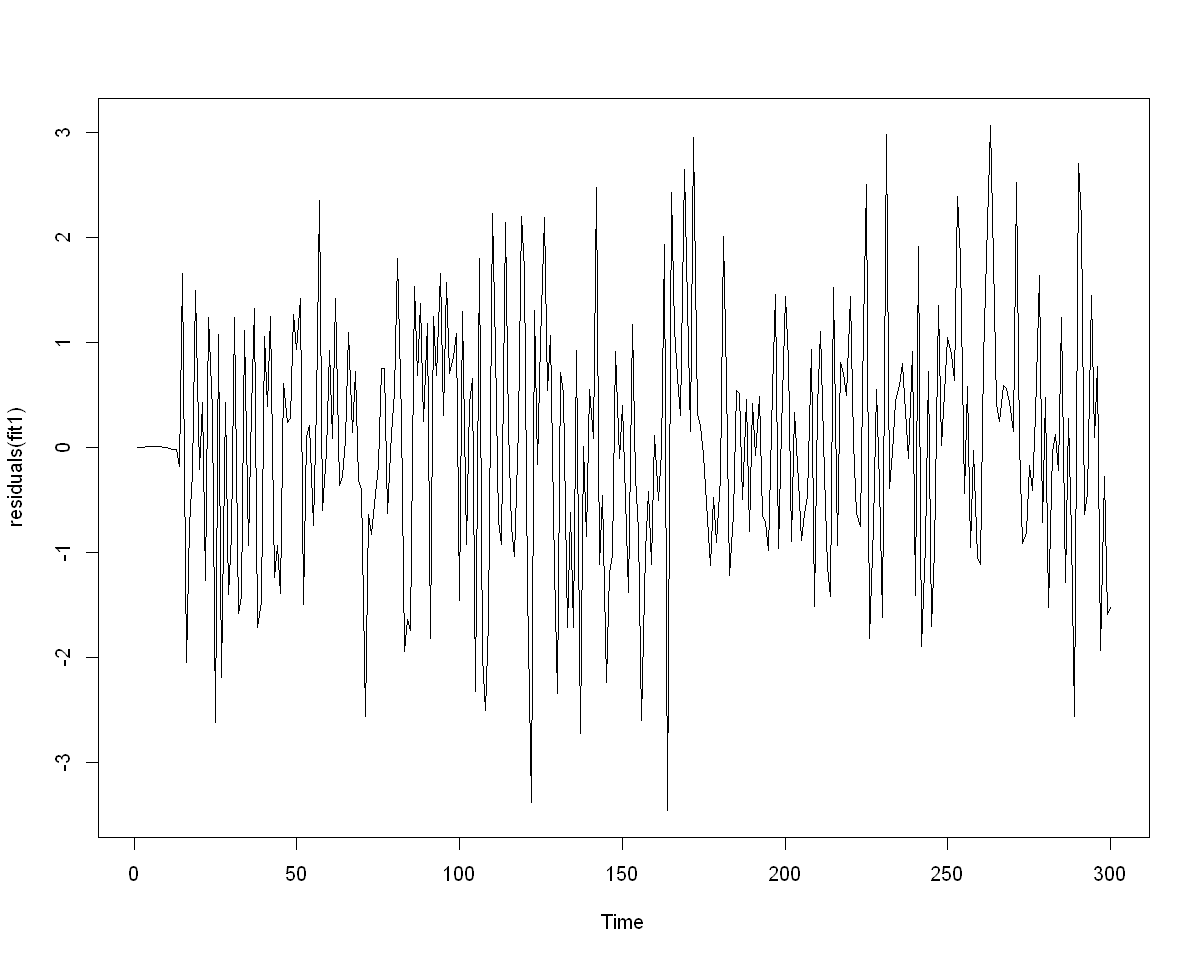

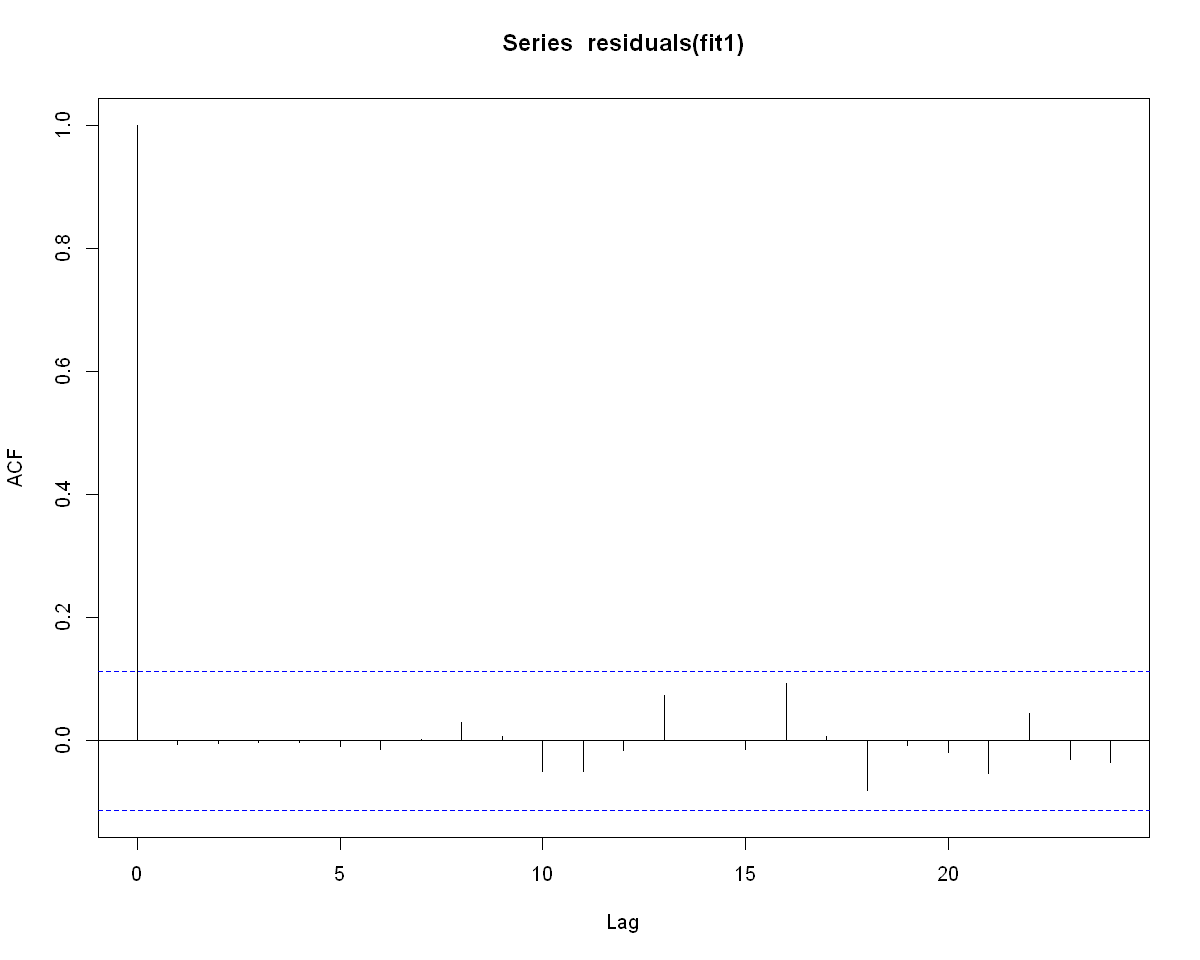

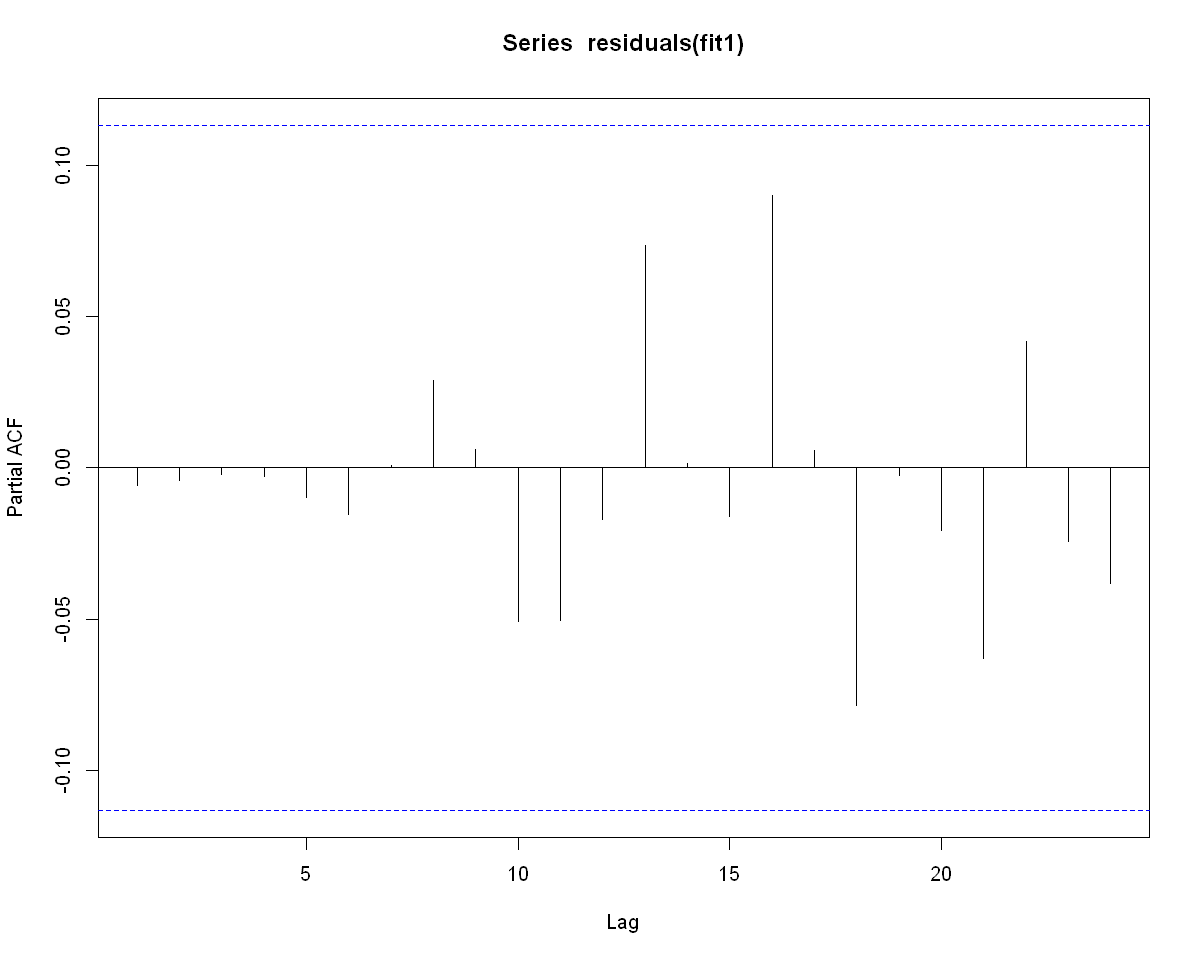

In [28]:
plot(residuals(fit1))
acf(residuals(fit1))
pacf(residuals(fit1))

Now we can see if our model residuals follows the theoretical normal distribution via both the qqplot, that compares the theoretical quantiles against the sample ones, and the histogram of the samples with the theoretical distribution superimposed.
As we can see both plots are good so we can continue.

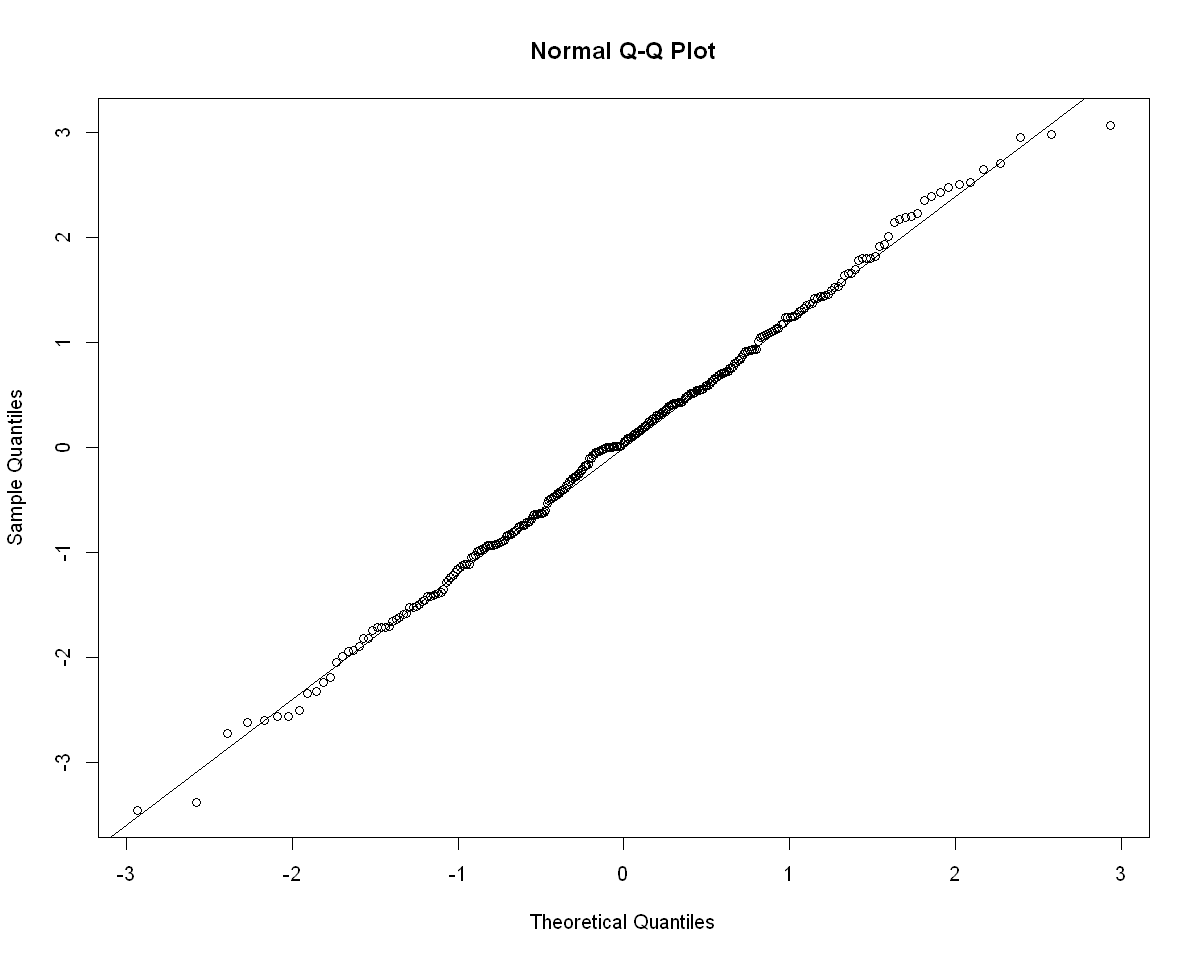

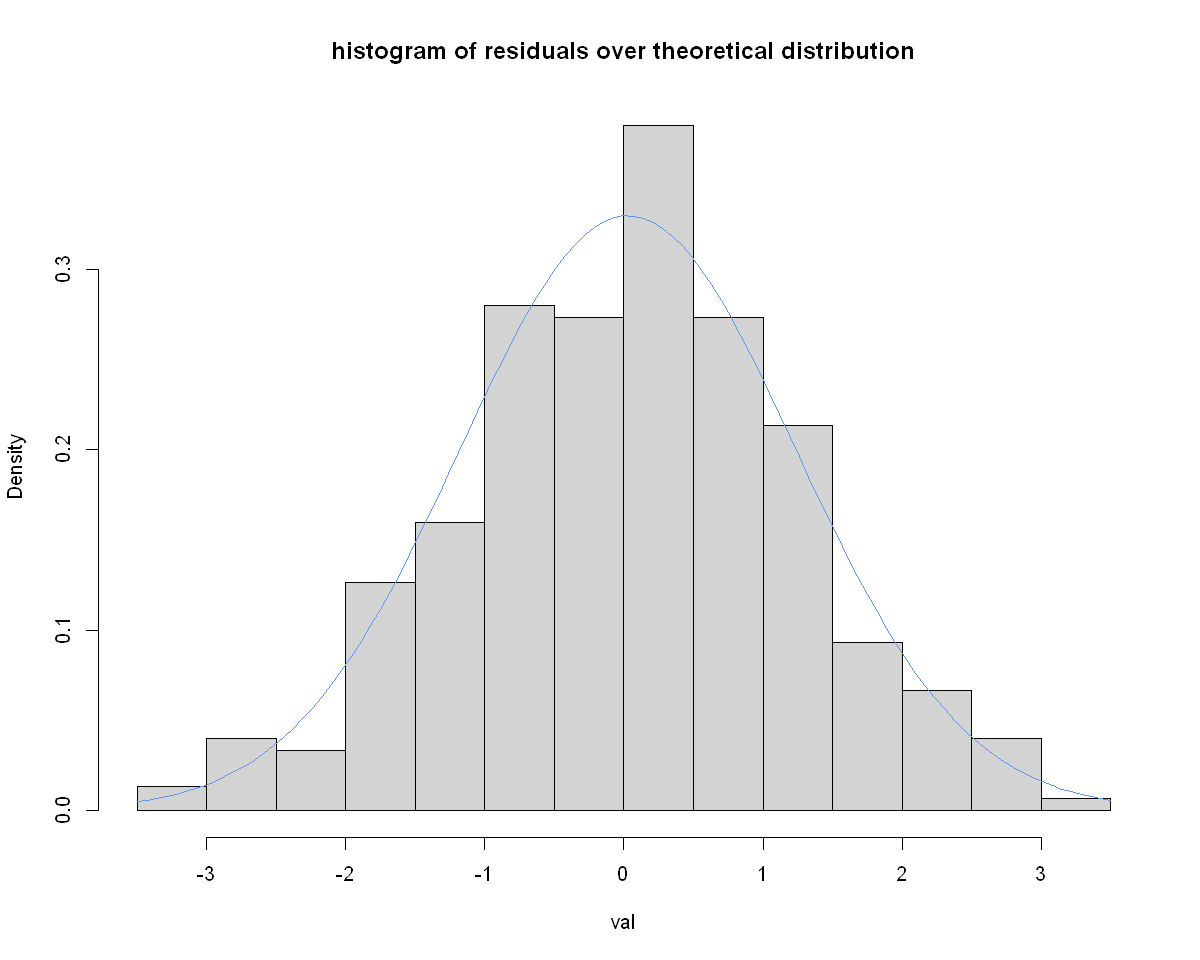

In [29]:
qqnorm(fit1$residuals)
qqline(fit1$residuals)
hist2(fit1$residuals, n = 20, main ="histogram of residuals over theoretical distribution")

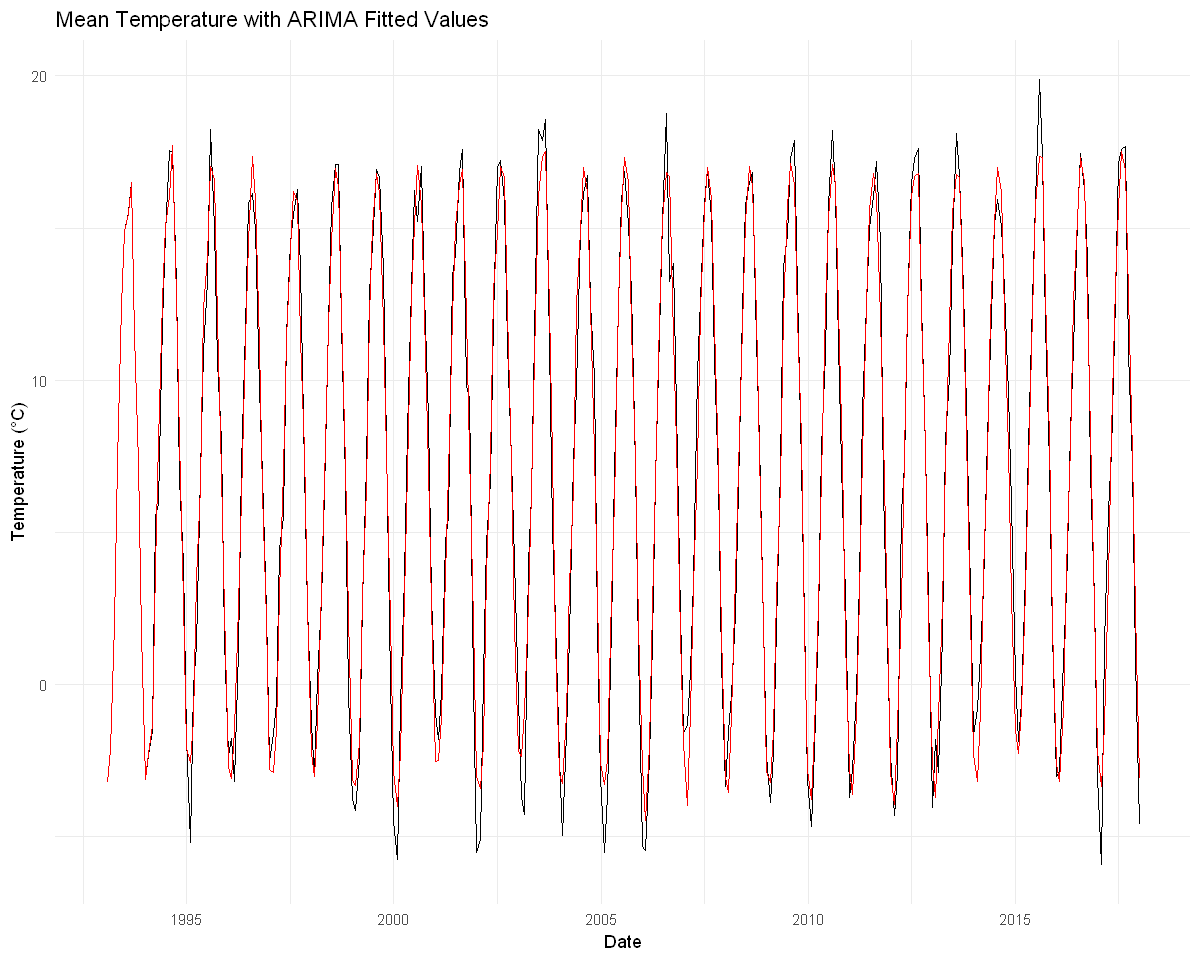

In [30]:
# Create a data frame for ggplot
plot_data <- data.frame(
  Date = index(train_test_data$train),
  Mean_Temperature = coredata(train_test_data$train),
  Fitted = fit1$fitted  # Add NA for the first differencing period
)

# Plot using ggplot
ggplot(plot_data, aes(x = Date)) +
  geom_line(aes(y = Mean_Temperature), color = "black") +
  geom_line(aes(y = Fitted), color = "red") +
  labs(title = "Mean Temperature with ARIMA Fitted Values",
       x = "Date",
       y = "Temperature (°C)") +
  theme_minimal()

Here is a plot of the time series analyzed in black and its fit via the SARIMA model in red, as anticipated before the model is good and we see it in this graph. \
Now for the fun part, we do a forecast of the same period of time we withdrawed to the original time series to test our forecast with the SARIMA model. \
For plotting purposes we will retain only the 95% CI from the forecast.

In [31]:
cast <- forecast(fit1, h=cast_time)

# to adapt forecast mean to the test date format
cast_mean <- xts(cast$mean, order.by = index(train_test_data$test))
cast_lower <- xts(cast$lower, order.by = index(train_test_data$test))
cast_upper <- xts(cast$upper, order.by = index(train_test_data$test))

#plot(cast_lower$`95%`)
combined_data_xts <- c(train_test_data$train,train_test_data$test)

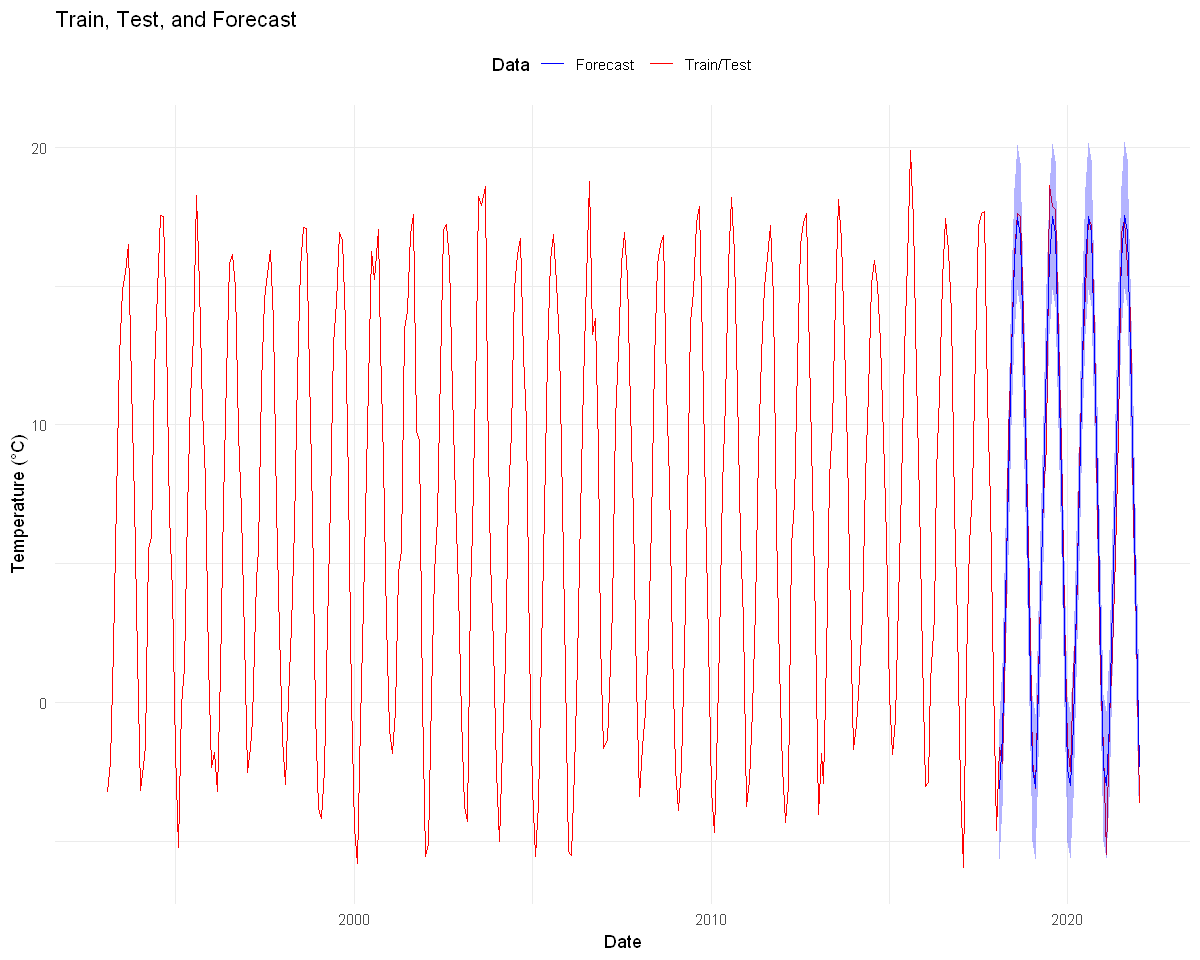

In [32]:
# Combine the train and test data into a data frame with dates as a column
combined_data_df <- data.frame(Date = index(combined_data_xts), Temperature = coredata(combined_data_xts))
#combined_data_df
# Convert forecast data to a data frame
forecast_data <- data.frame(Date = index(cast_mean), 
                            Mean = coredata(cast_mean),
                            Lower = coredata(cast_lower$`95%`),
                            Upper = coredata(cast_upper$`95%`))

#forecast_data
# Plot using ggplot
ggplot() +
  geom_line(data = combined_data_df, aes(x = Date, y = Mean_Temperature, color = "Train/Test"), size = 0.3) +
  geom_line(data = forecast_data, aes(x = Date, y = Mean, color = "Forecast"), size = .5) +
  geom_ribbon(data = forecast_data, aes(x = Date, ymin = X95., ymax = X95..1), fill = "blue", alpha = 0.3) +
  labs(x = "Date", y = "Temperature (°C)", title = "Train, Test, and Forecast") +
  scale_color_manual(name = "Data", values = c("Train/Test" = "red", "Forecast" = "blue")) +
  theme_minimal() +
  theme(legend.position = "top")

MSE of prediction over test set: 1.641667 


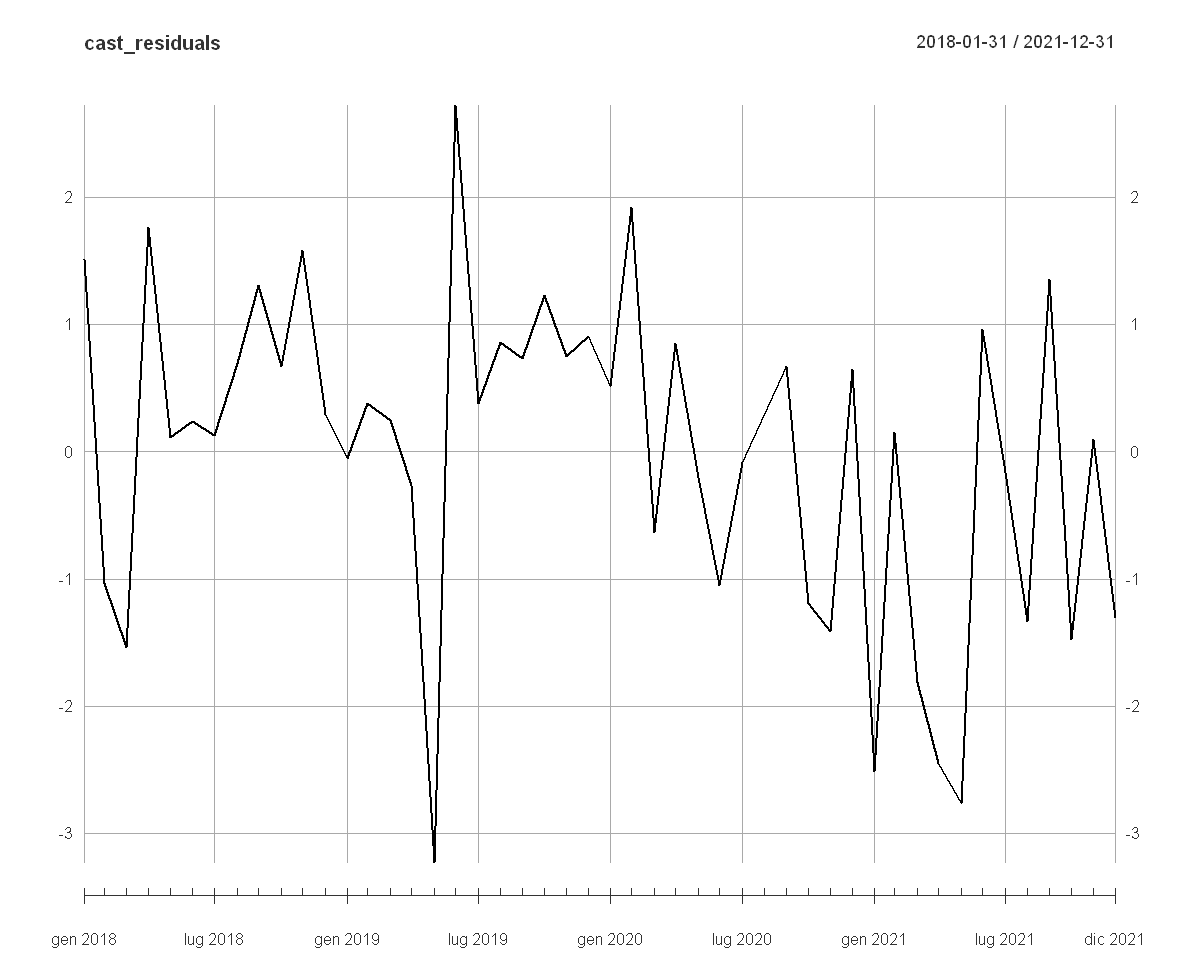

In [33]:
# compute forecast residuals over test
cast_residuals <- train_test_data$test - cast_mean
plot(cast_residuals)
MSE <- mean(cast_residuals**2)
cat("MSE of prediction over test set:", MSE, "\n")

As we can see the forecast is we aligned with the test data, but the model is rudimental as the shape of the prediction is always the same for every year. \
Maybe using daily or weekly averaged data could've changed that, but it also would've complicated the analysis much more. \
Computing the residuals of prediction over the test set that we can see above allows us to calculate the MSE of the prediction over the test set:
the value of 1.55 tells us that the forecast is valid.

Additionally we could now forecast into new points that we don't have access to through the datasets we have:

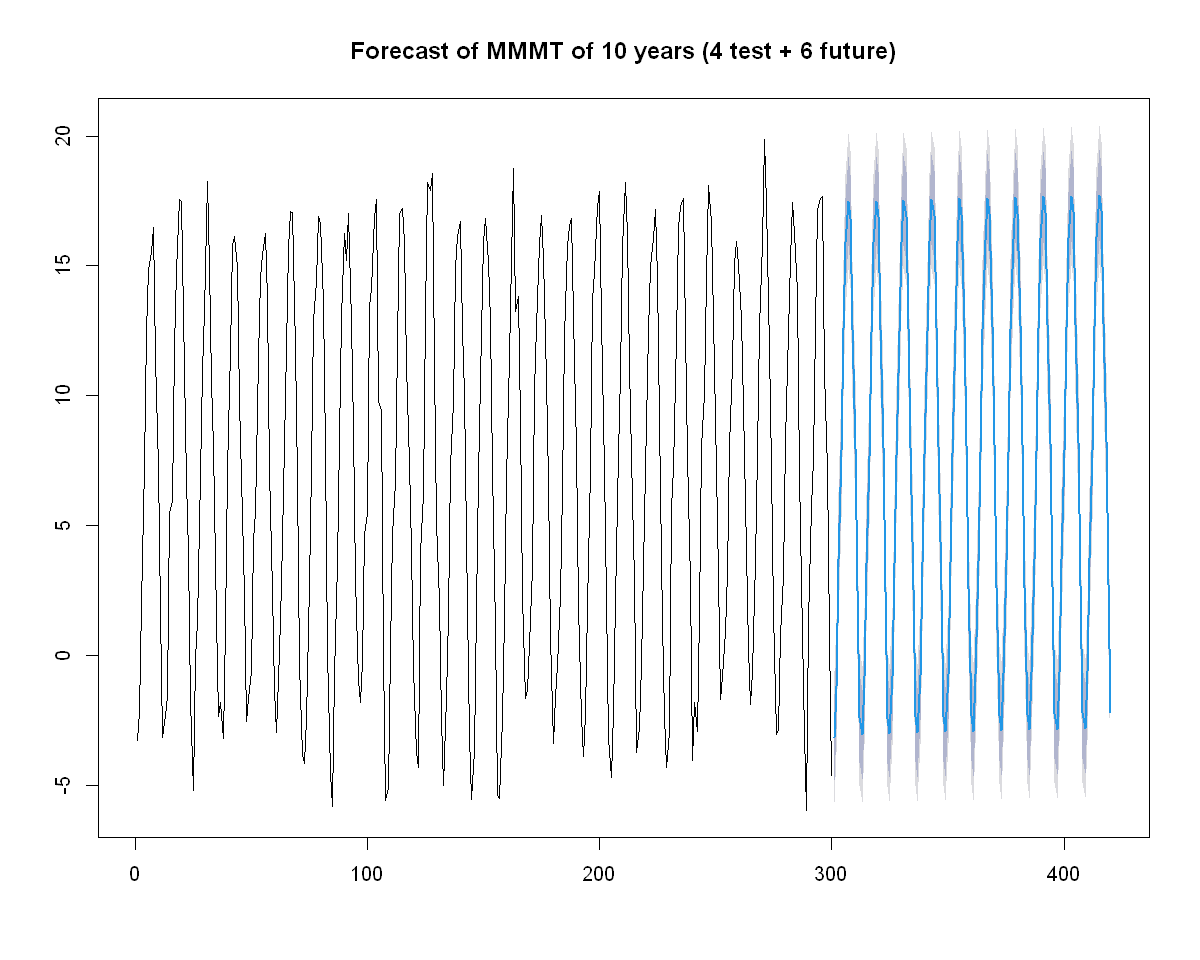

In [34]:
future_cast <- forecast(fit1, h=120)
plot(future_cast, main = "Forecast of MMMT of 10 years (4 test + 6 future)")

We are happy with this forecast of 6 years worth of future temperatures of months mean. \
Now just to see that even this SARIMA model predicts a rising trend in temperatures we'll do a forecast of 25 years, this way we can see clearly the rising trend. \
Even if the model is good we have to note that predicting new data points in a bigger size than the train set makes our forecast not a very reliable one, this is only to visualize the rising trend more clearly! \
However, we can see from the Credible Intervals that we somewhat retain good accuracy and our prediction does not diverge that much.

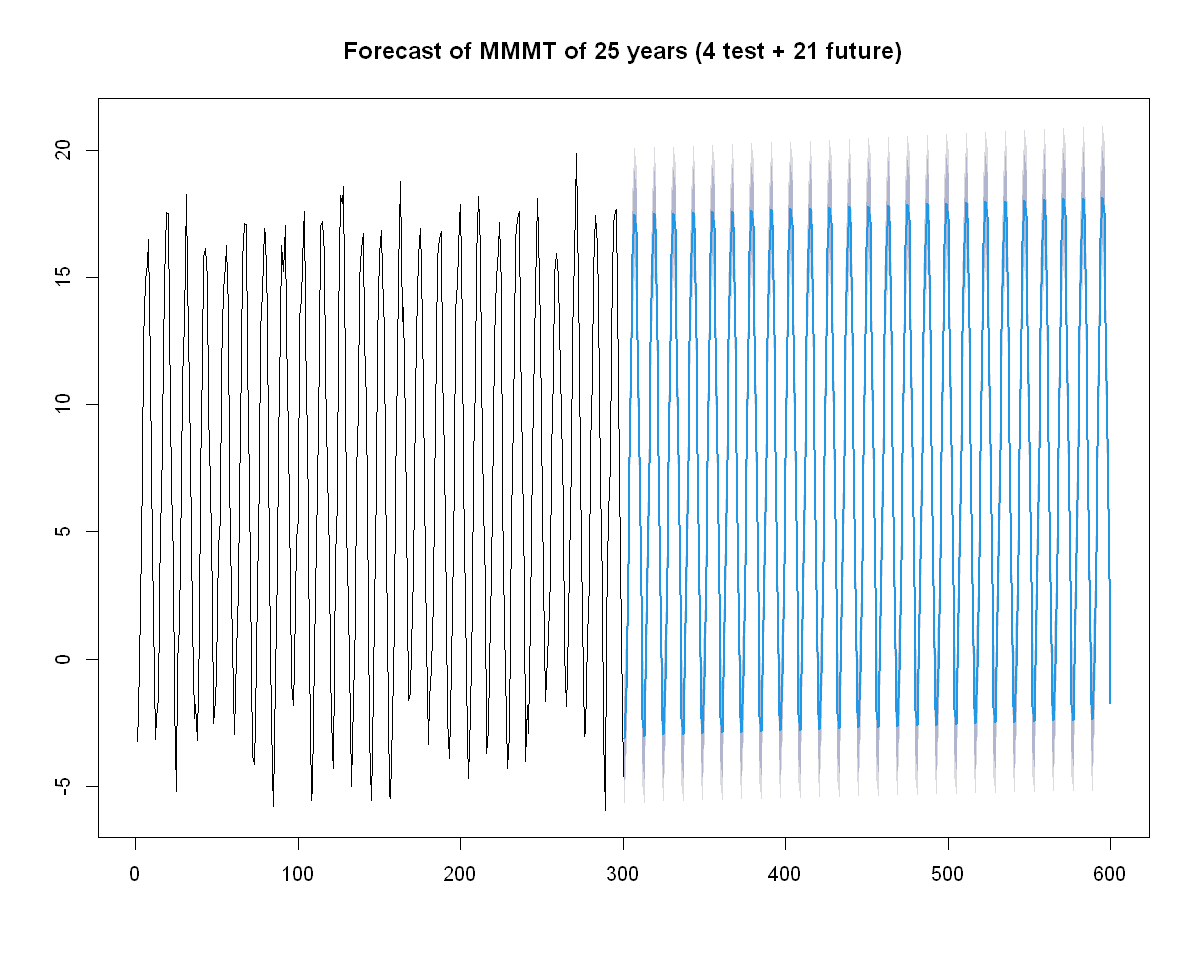

In [35]:
future_cast <- forecast(fit1, h=25*12)
plot(future_cast, main = "Forecast of MMMT of 25 years (4 test + 21 future)")

# Analysis for mean year temperature

Now for the sake of trying other methods we tried to analyze the yearly means of the daily average, this way our ARIMA model doesn't have to deal with seasonality as it's taken care by the mean function itself at the beginning, however we can see that the model performance is worse, probably because the lack of data fed to the ARIMA model itself. 

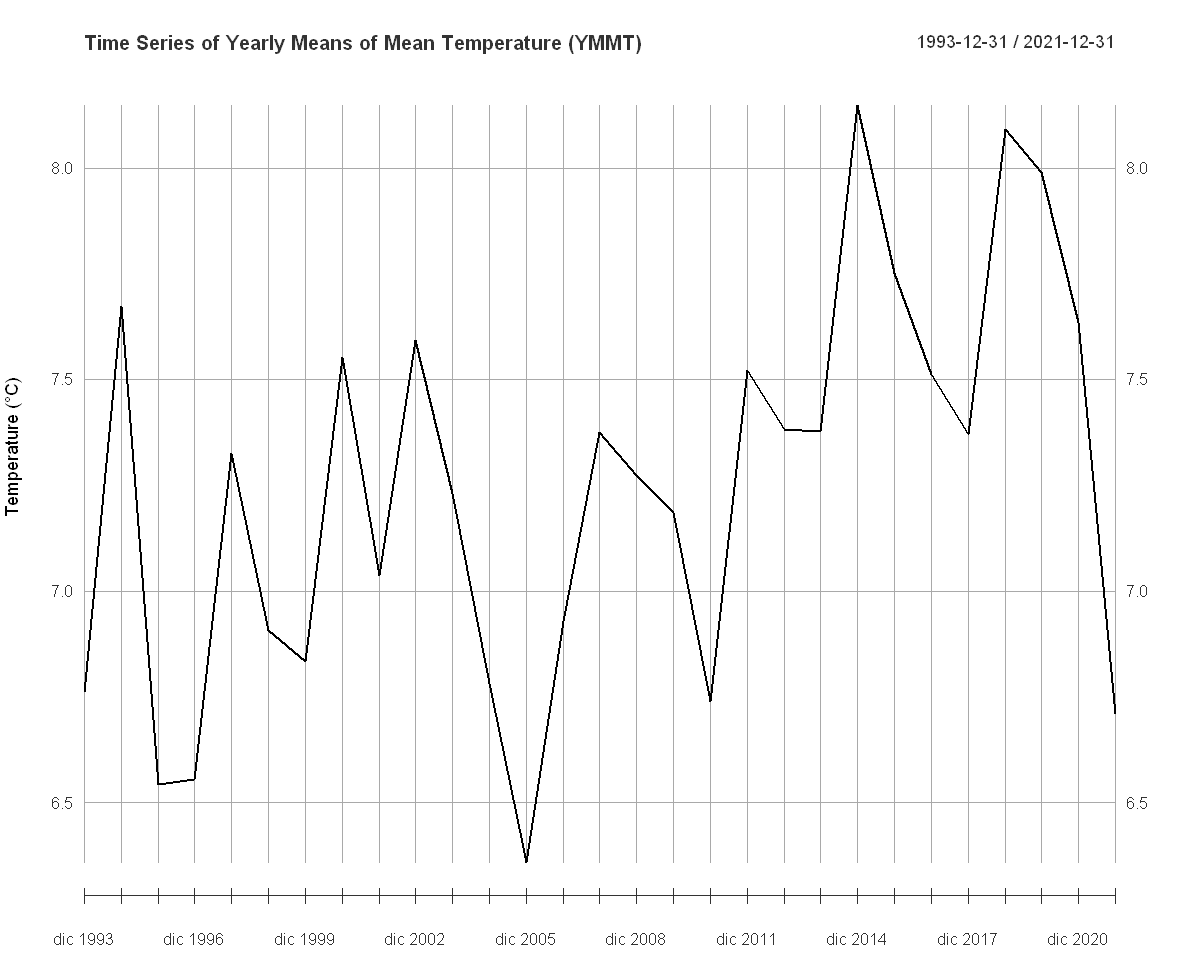

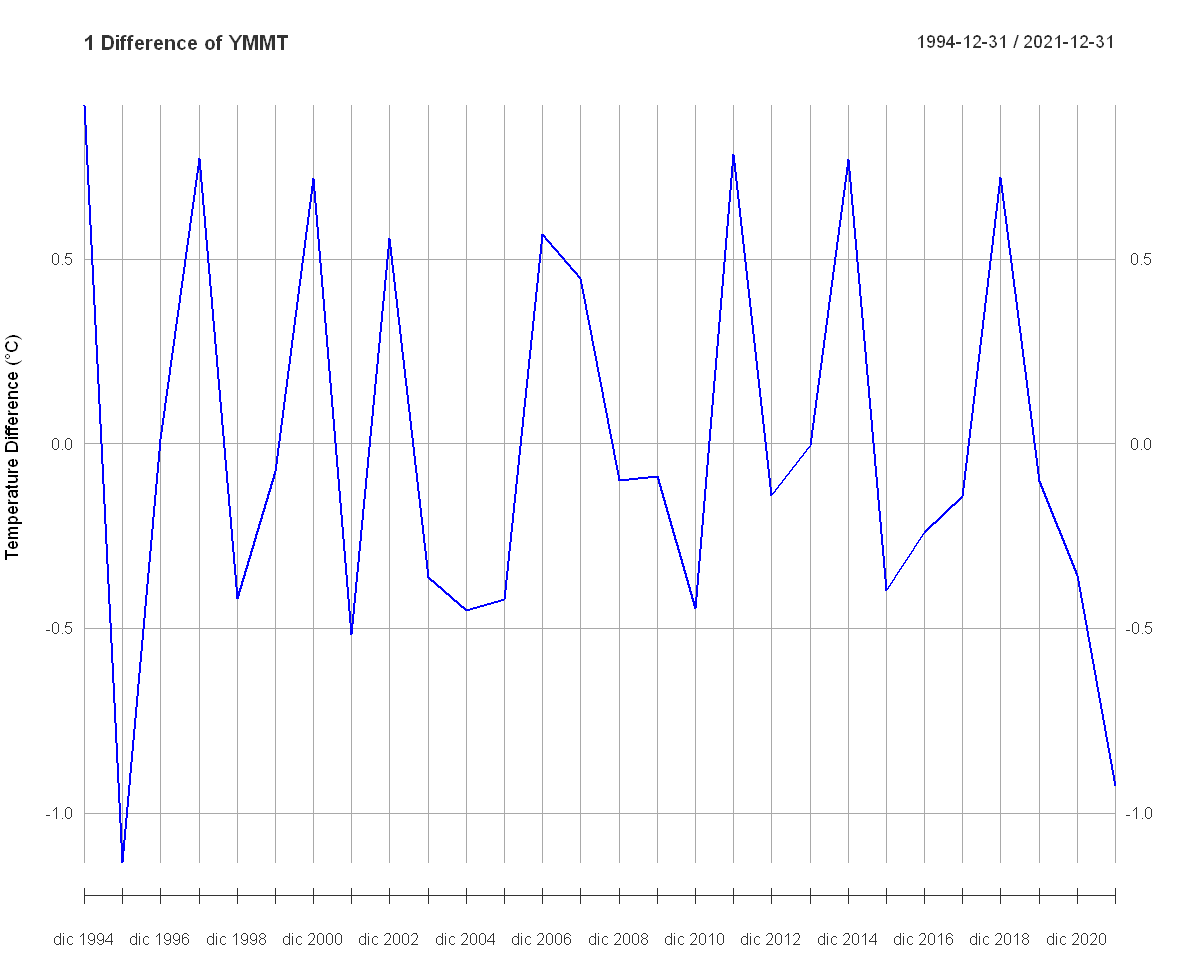

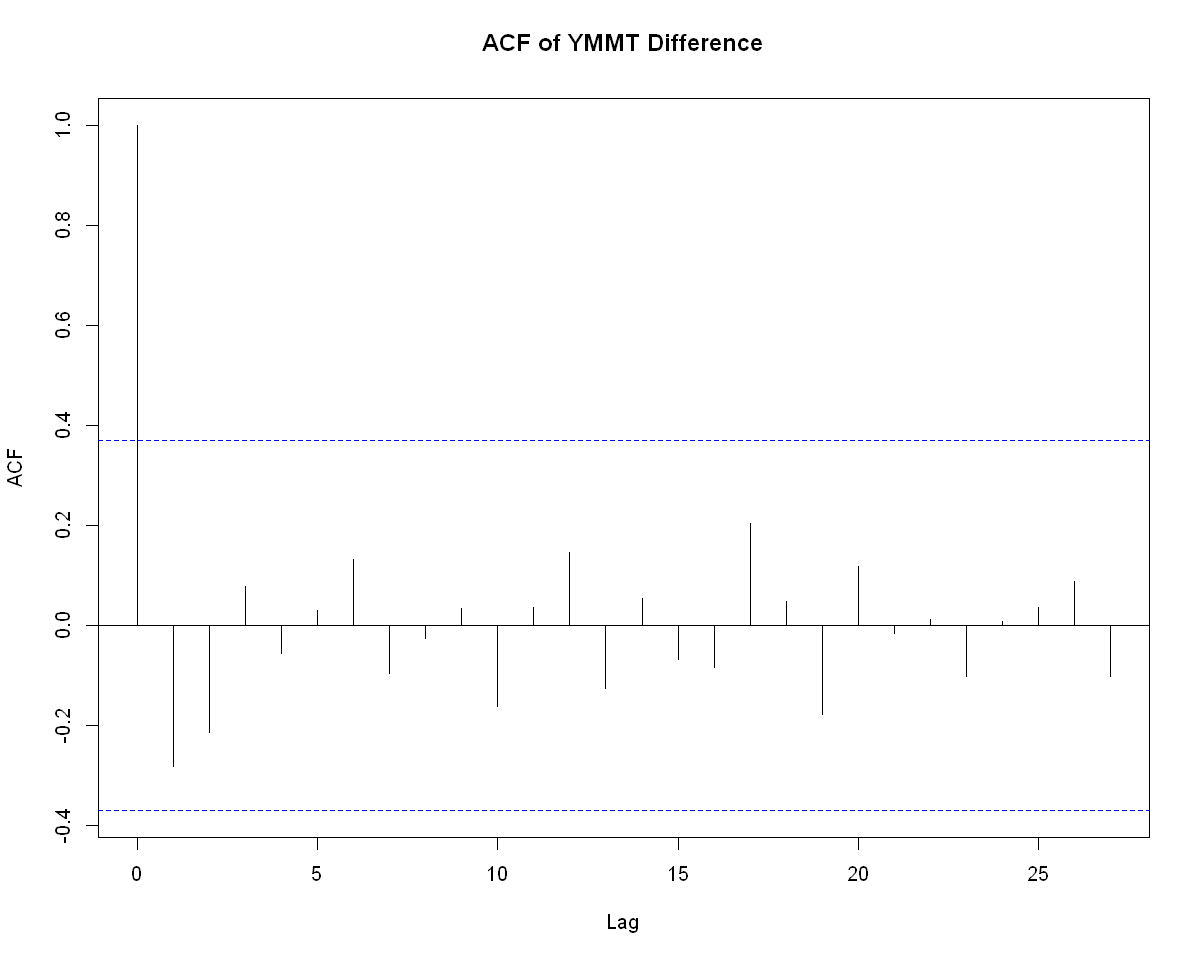

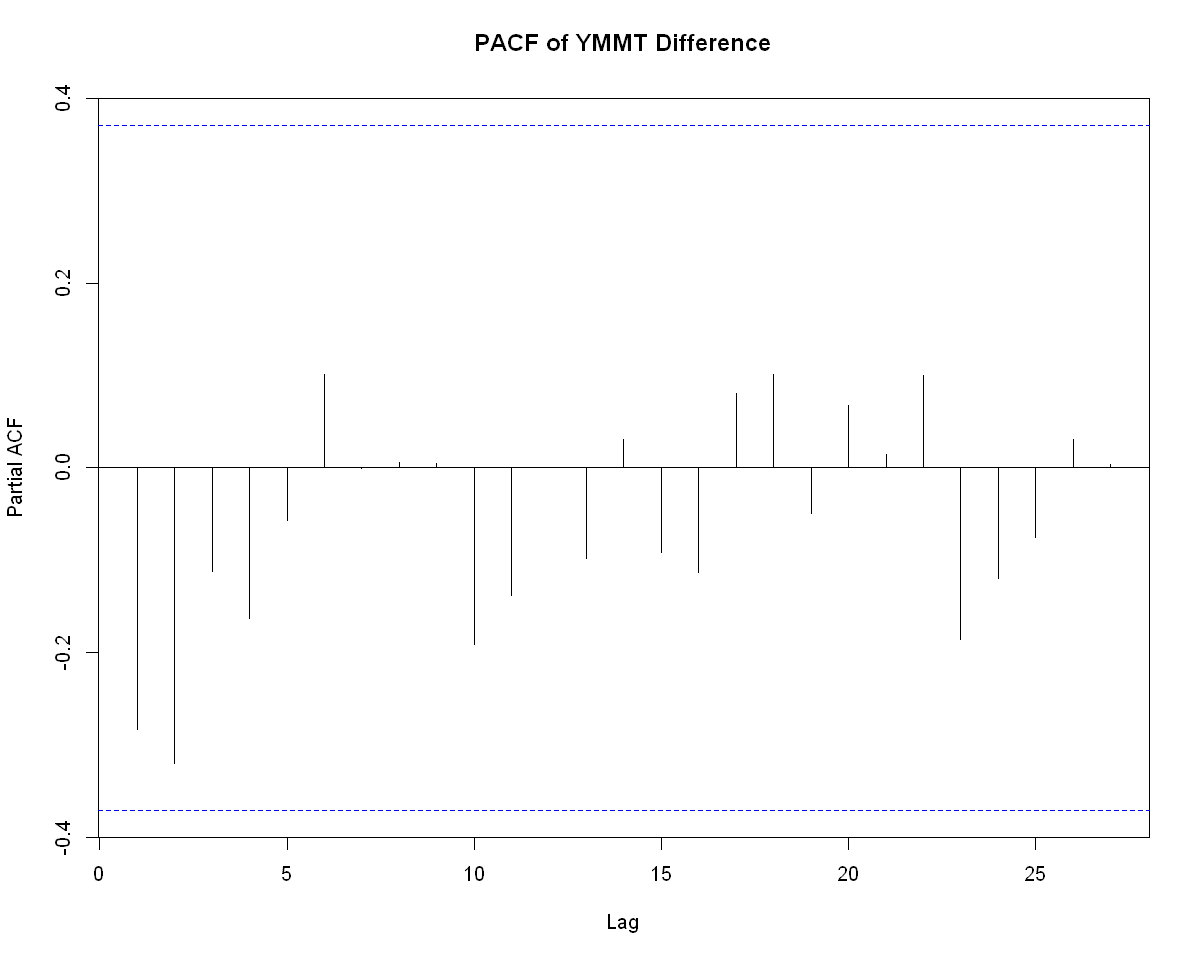

In [36]:
# Load necessary packages
library(xts)
library(forecast)

# Convert the data frame to an xts object
#data_xts <- xts(data[, c("Max_Temperature", "Min_Temperature", "Mean_Temperature")], order.by = data$Date)

# Aggregate monthly mean data
ep3 <- endpoints(data_xts, on = "years")
yearly_mean <- period.apply(data_xts, INDEX = ep3, FUN = colMeans)

# Plot 1: Time Series as it is with xts
plot(yearly_mean$Mean_Temperature, main = "Time Series of Yearly Means of Mean Temperature (YMMT)", ylab = "Temperature (°C)")

# Plot 2: Difference 1
diff_data <- na.omit(diff(yearly_mean$Mean_Temperature))
plot(diff_data, main = "1 Difference of YMMT", ylab = "Temperature Difference (°C)",col = "blue")

# Plot 3: ACF
acf(diff_data, 40, main = "ACF of YMMT Difference")

# Plot 4: PACF
pacf(diff_data, 40, main = "PACF of YMMT Difference")


In [37]:
# qua abbiamo fatto ARIMA
source("sse_v4.lib")
#fit2 <- auto.arima(yearly_mean$Mean_Temperature)
fit2 <- Arima(yearly_mean$Mean_Temperature, order = c(2,1,1), include.mean = TRUE, include.drift = F)

stat.mod(fit2)
BIC(fit2)

jqtest <- jarque.bera.test(fit2$residuals)
print(jqtest)

                                               
-------------- Stime dei parametri ----------- 
           Coef   Std.Err      tstat        pval
ar1  0.03218138 0.2979649  0.1080039 0.913992581
ar2 -0.27306031 0.2727926 -1.0009812 0.316835879
ma1 -0.67876567 0.2612663 -2.5979836 0.009377296
                                                
----------------------------------------------- 
     sigma2         AIC      loglik 
  0.2234545  43.2987474 -17.6493737 
                                               
-------------Test di Ljung-Box --------------- 
     statistic gdl pvalue   
[1,] 4.699614  15  0.9943786


[1] 48.62757


	Jarque Bera Test

data:  fit2$residuals
X-squared = 0.59742, df = 2, p-value = 0.7418



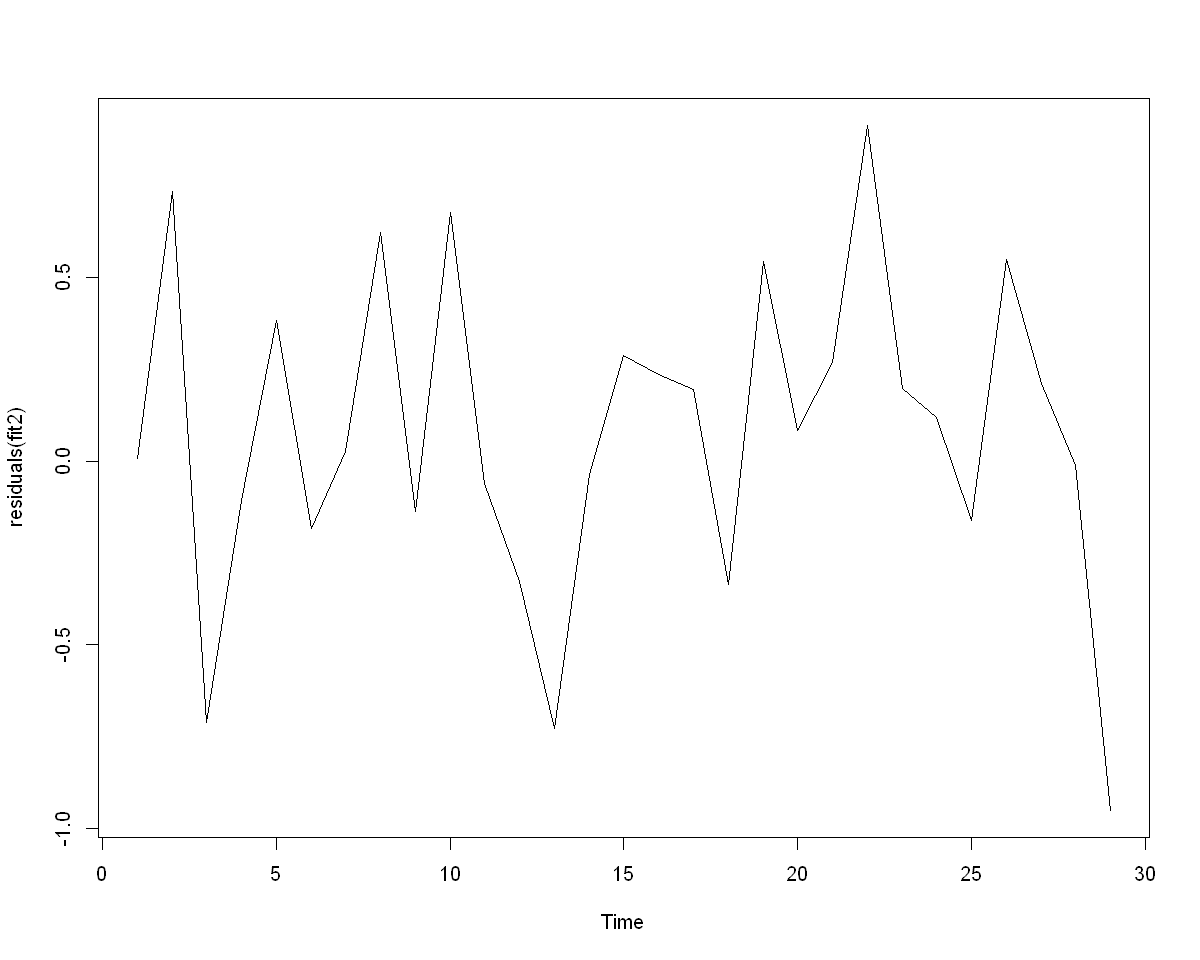

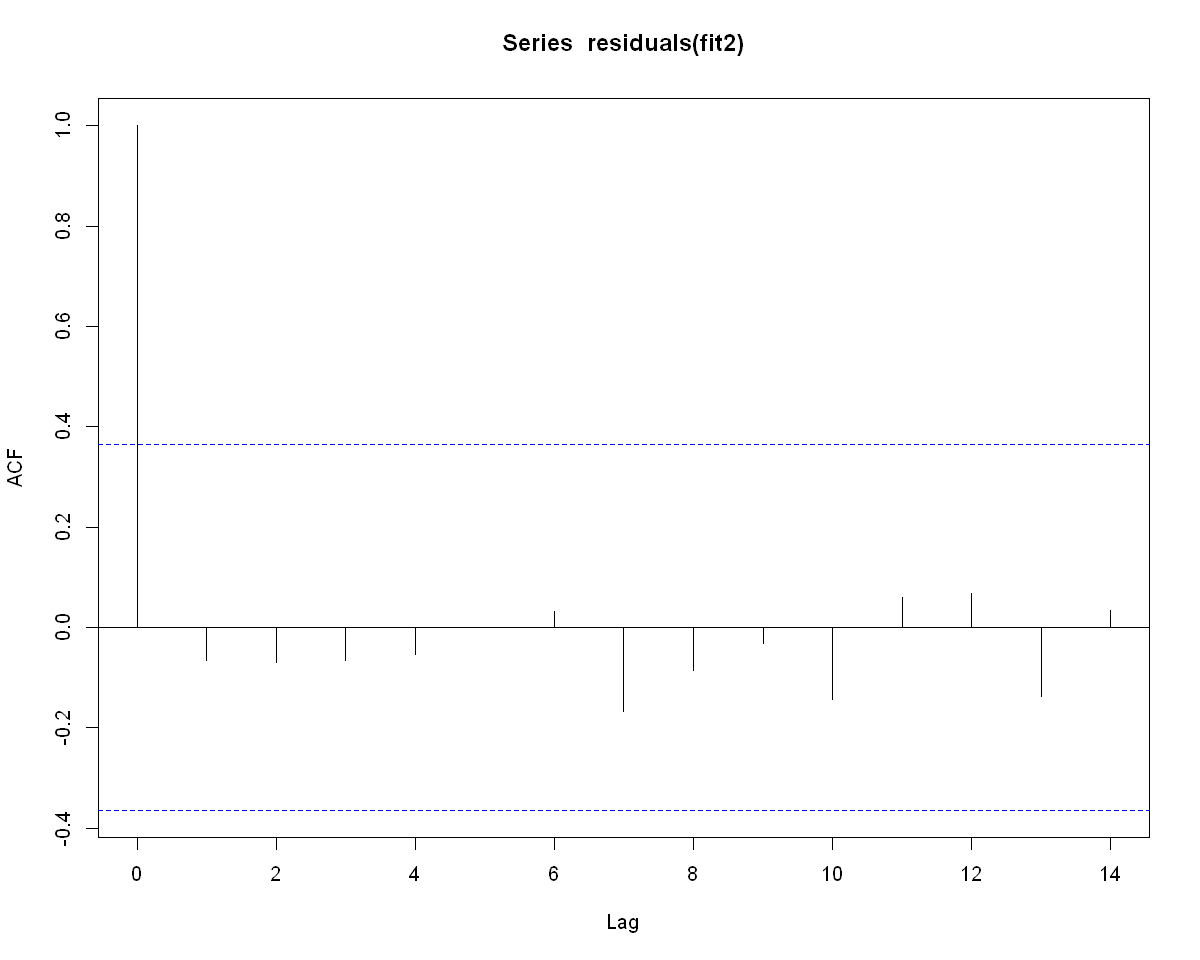

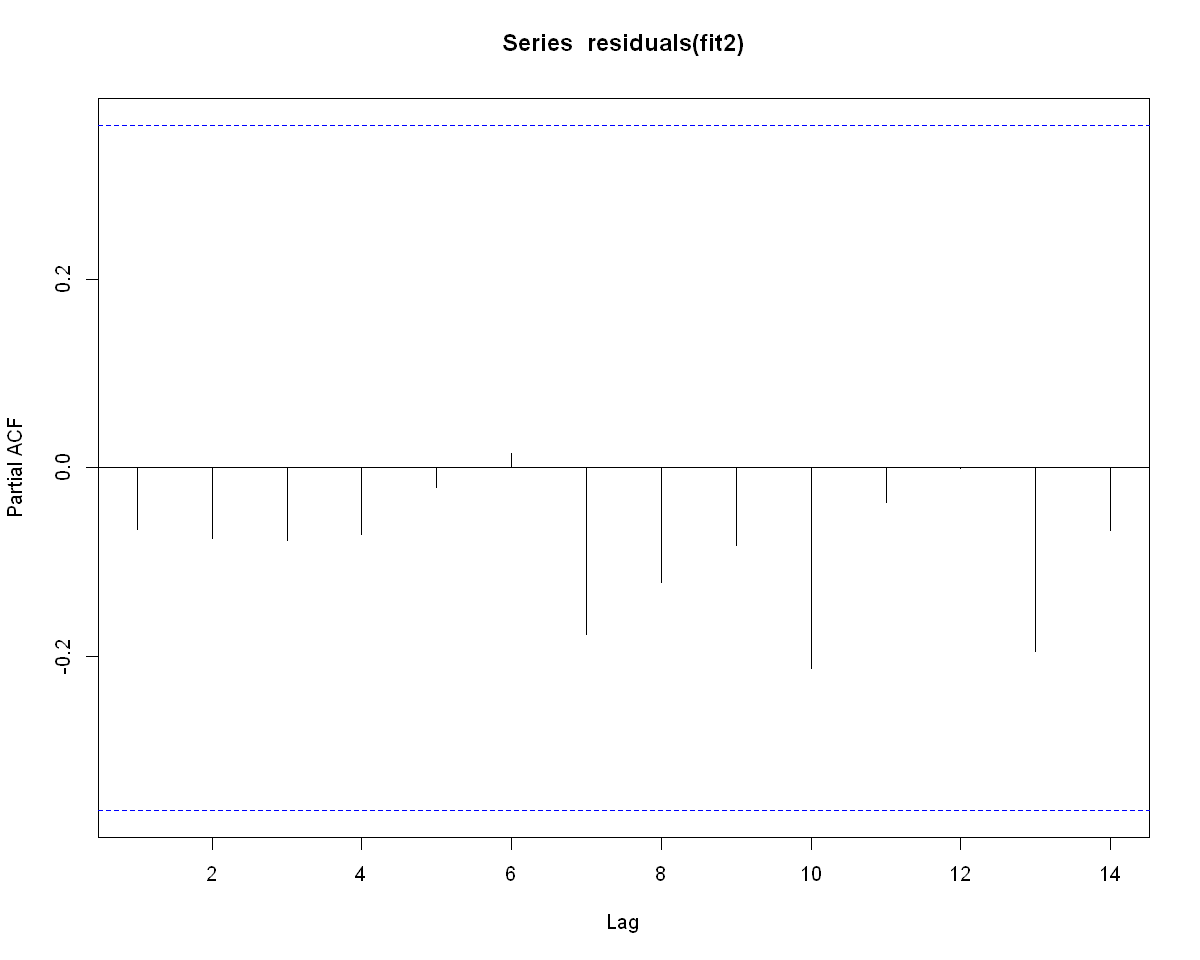

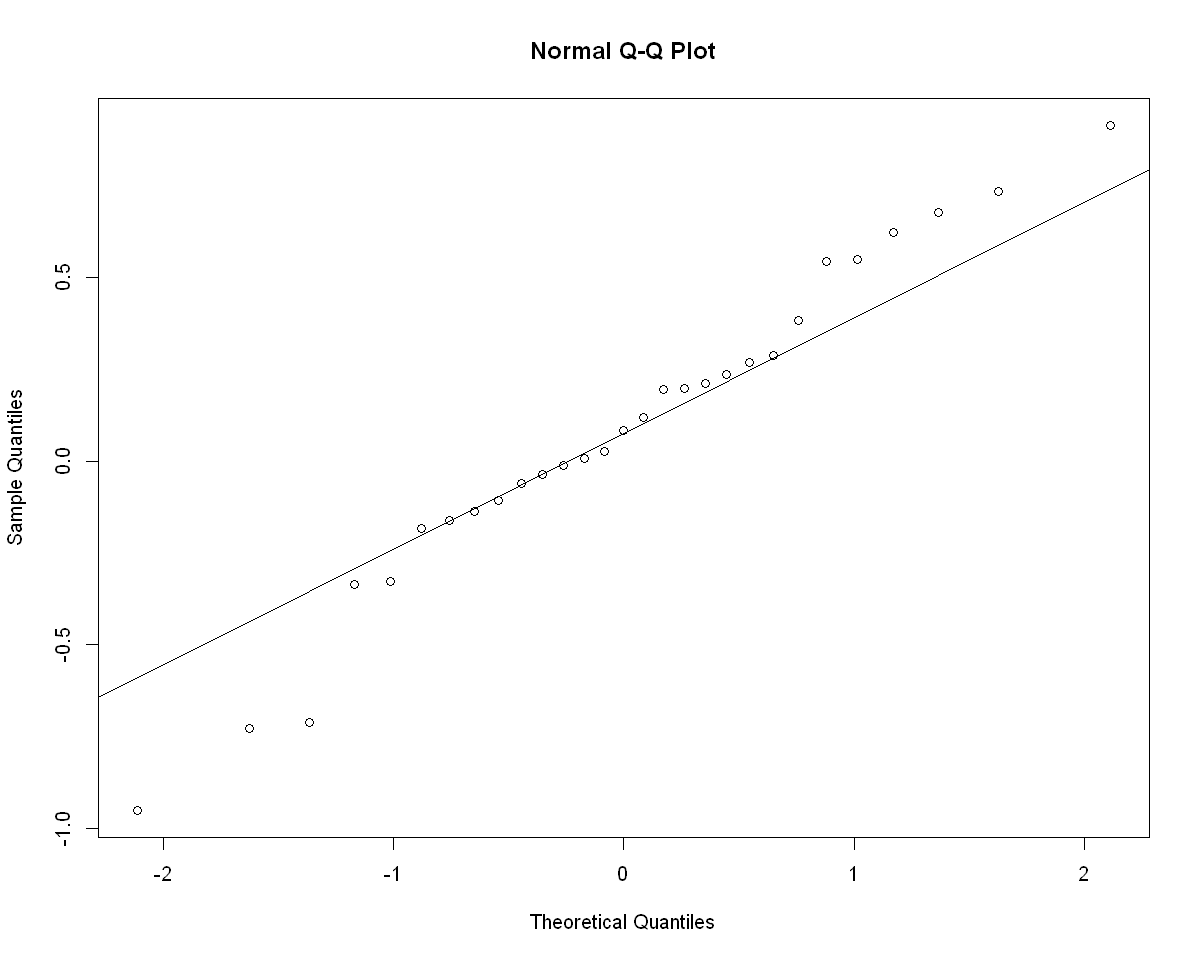

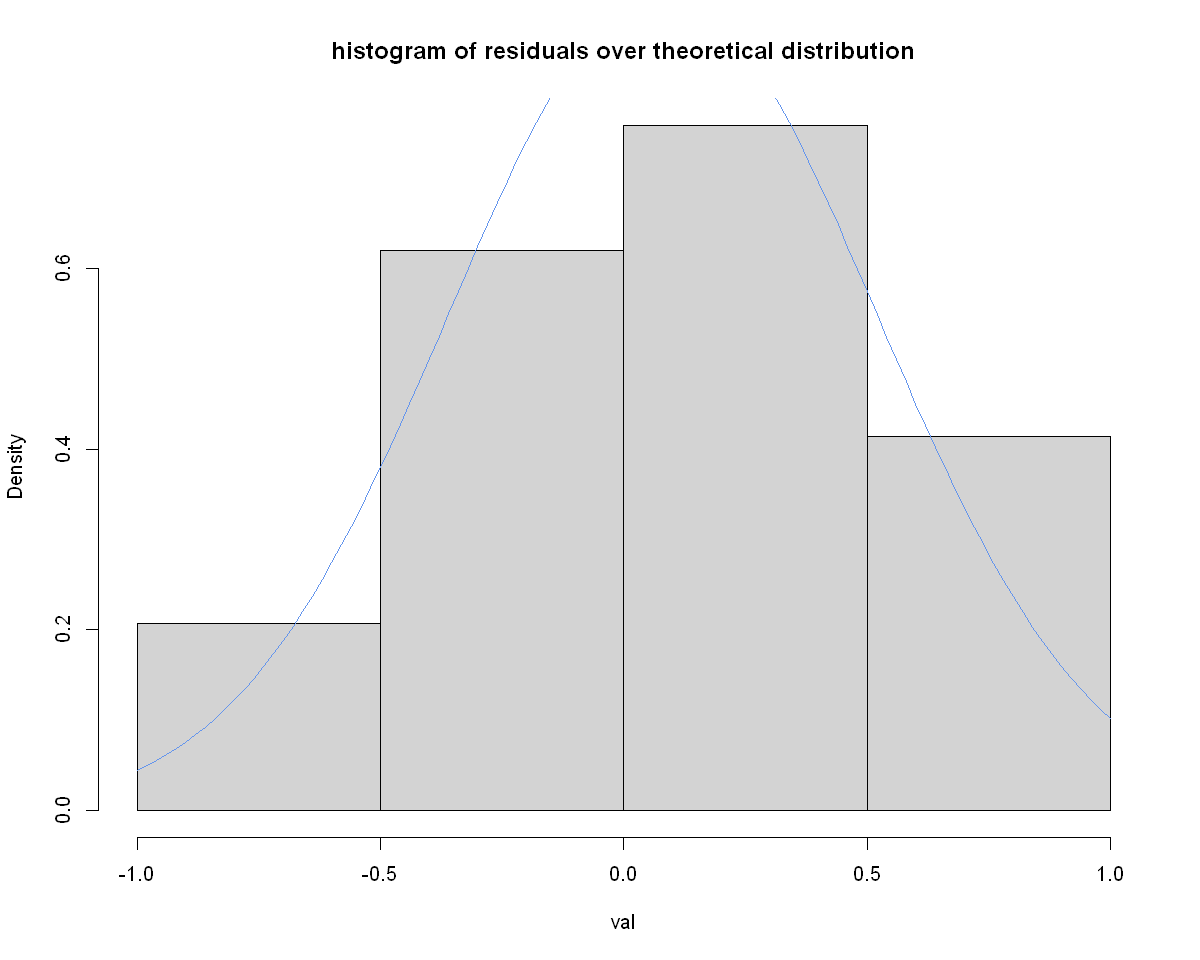

In [38]:
plot(residuals(fit2))
acf(residuals(fit2))
pacf(residuals(fit2))
qqnorm(fit2$residuals)
qqline(fit2$residuals)
hist2(fit2$residuals, n = 4, main = "histogram of residuals over theoretical distribution")

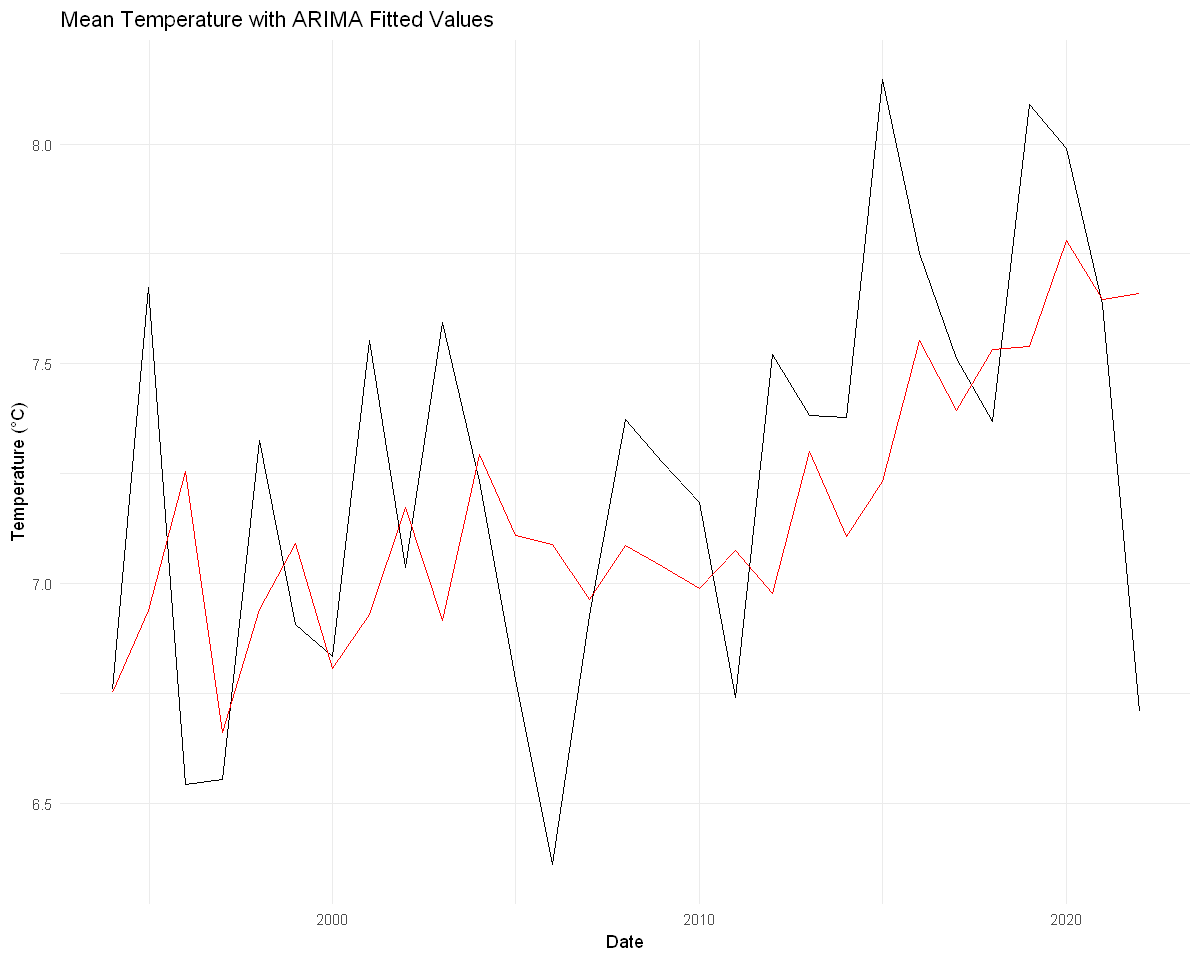

In [39]:
# Create a data frame for ggplot
plot_data_yearly <- data.frame(
  Date = index(yearly_mean),
  Mean_Temperature = coredata(yearly_mean$Mean_Temperature),
  Fitted = fit2$fitted
)

# Plot using ggplot
ggplot(plot_data_yearly, aes(x = Date)) +
  geom_line(aes(y = Mean_Temperature), color = "black") +
  geom_line(aes(y = Fitted), color = "red") +
  labs(title = "Mean Temperature with ARIMA Fitted Values",
       x = "Date",
       y = "Temperature (°C)") +
  theme_minimal()

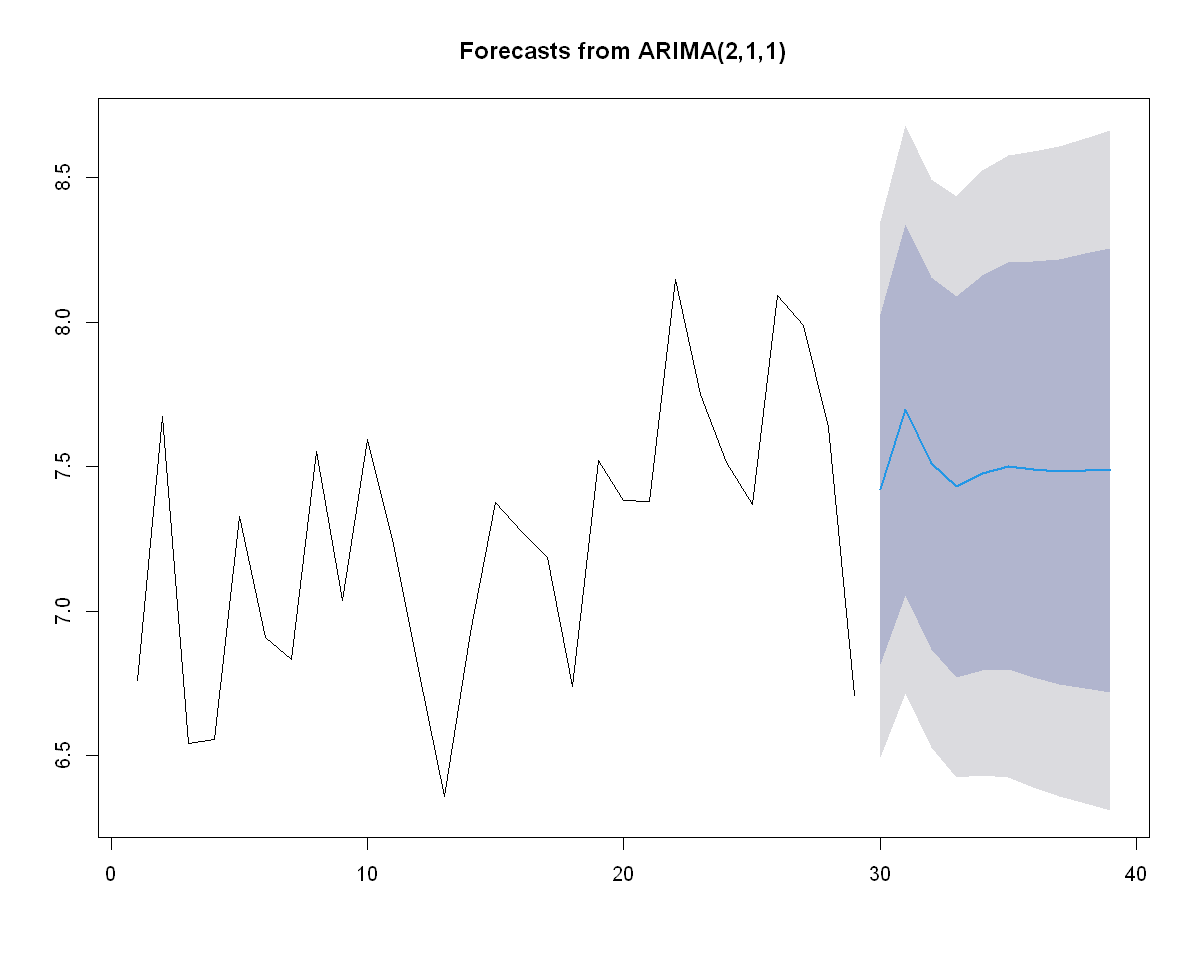

In [40]:
cast_year <- forecast(fit2, h=10)
plot(cast_year)

## comparison with SNPA DATA

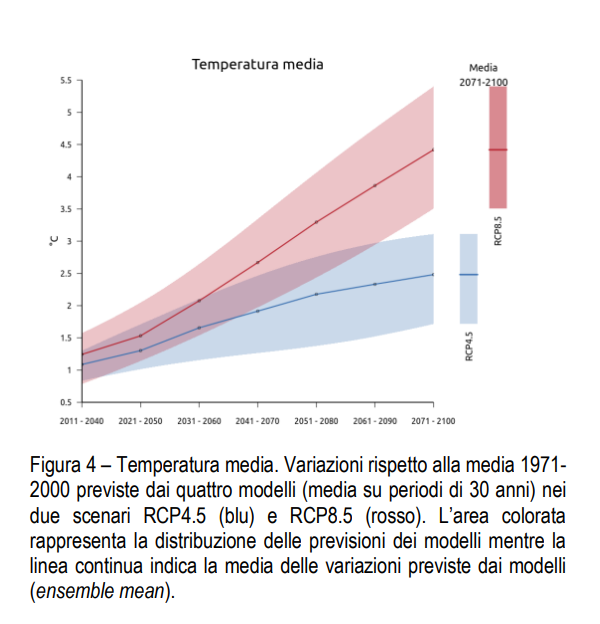

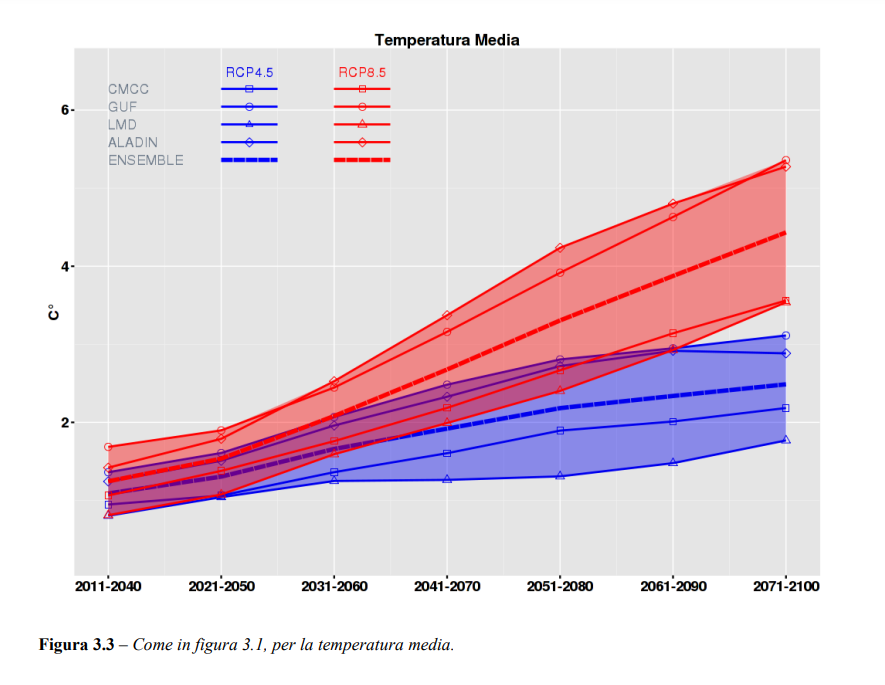

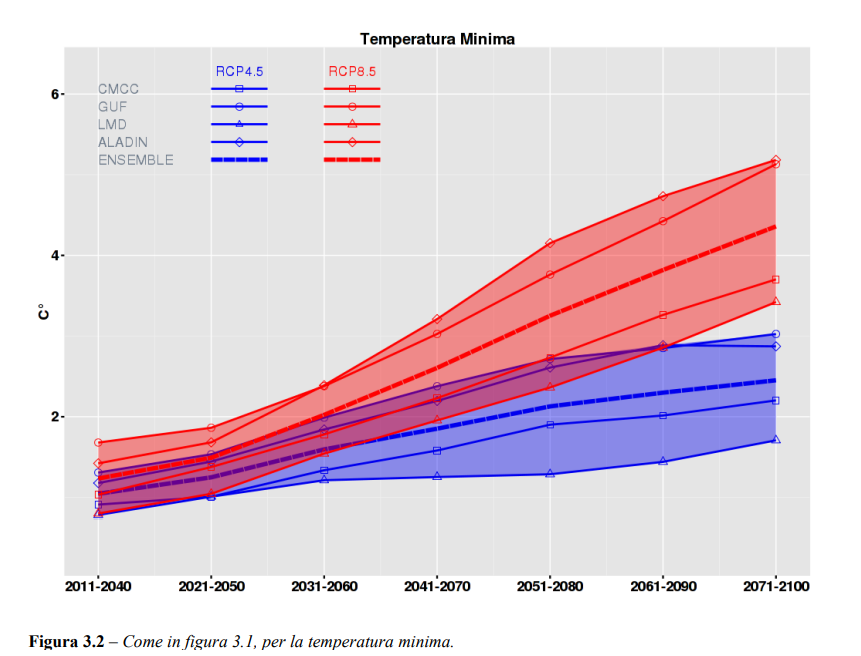

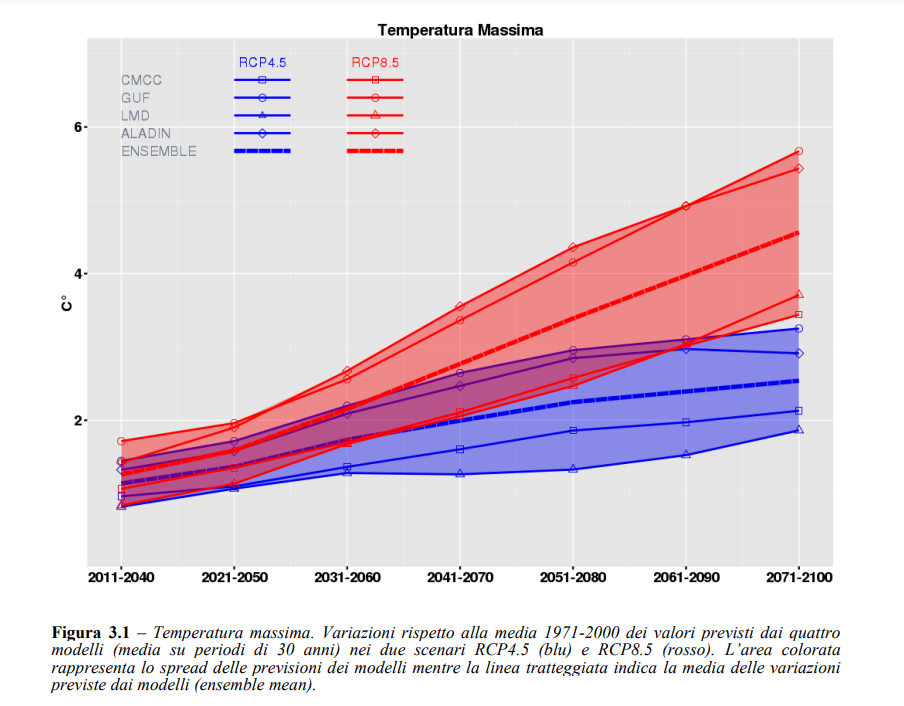

In [41]:
display_png(file="snpa1.png" ,width = 500)
display_png(file="snpa3.png" ,width = 250)
display_png(file="snpa4.png" ,width = 250)
display_png(file="snpa6.png" ,width = 250)

In this chart taken from the SNPA 2020/21 report, we see the forecast made up to the year 2090 using 4 different models and averaging the results obtained from them. This forecast was made for two RCP scenarios. Representative Concentration Pathways (RCP) are climate change scenarios used to project future greenhouse gas concentrations. These pathways (or trajectories) describe future greenhouse gas concentrations (not emissions), and here we have considered RCP 4.5 and RCP 8.5. The lower RCP values are more desirable for humans but would require more stringent climate change mitigation efforts to achieve them. \
The trend of the ensemble mean (the average of the variations predicted by the 4 models) is 0.2°C per decade in the RCP 4.5 scenario and 0.4°C per decade in the RCP 8.5 scenario. \
The study reports an increase in the average temperature across the territory of approximately 1.5 to 2.0°C in the period 2021-2050, between 2.75 and 3.25°C in the period 2041-2070, and between 3.75 and 4.50°C in the period 2061-2090. \ 
In our study, we did not consider the different RCP scenarios and we also have much less data, concentrated only in the Veneto region, so our results are certainly less significant. However, we can qualitatively observe a clear increase in temperature over the course of 25 years, confirming the study conducted by SNPA. 


# Bibliography
## [1] https://www.snpambiente.it/wp-content/uploads/2021/06/Rapporto-SNPA-21_2021.pdf
## [2] https://cran.r-project.org/web/packages/forecast/index.html